<center>
    <h1 style="text-align: center"> 
        Volatility of Returns: Analysis of Amgen Inc.
    </h1>
    <h3>
        Summer Semester 2021/2022 <br/>
        Martin Řanda & Matěj Kořínek
    </h3>
</center>


In [5]:
pacman::p_load(rstudioapi, dplyr, xts, tidyr, ggplot2, forecast, highfrequency, rugarch, future, Metrics, reshape2, aod, sandwich)
Sys.setlocale("LC_TIME", "English")
load("amgn.RData")

[1] "English_United States.1252"

The objective of this project is to analyze and forecast the volatility of returns on the amgn stock from May 2010 to late January 2016. Amgen Inc. (ticker amgn) is a multinational pharmaceutical company known for its production of a wide range of drugs, some of which are, for example, used for the treatment of arthritis or leukemia.

# 1. Data description

### Series plots

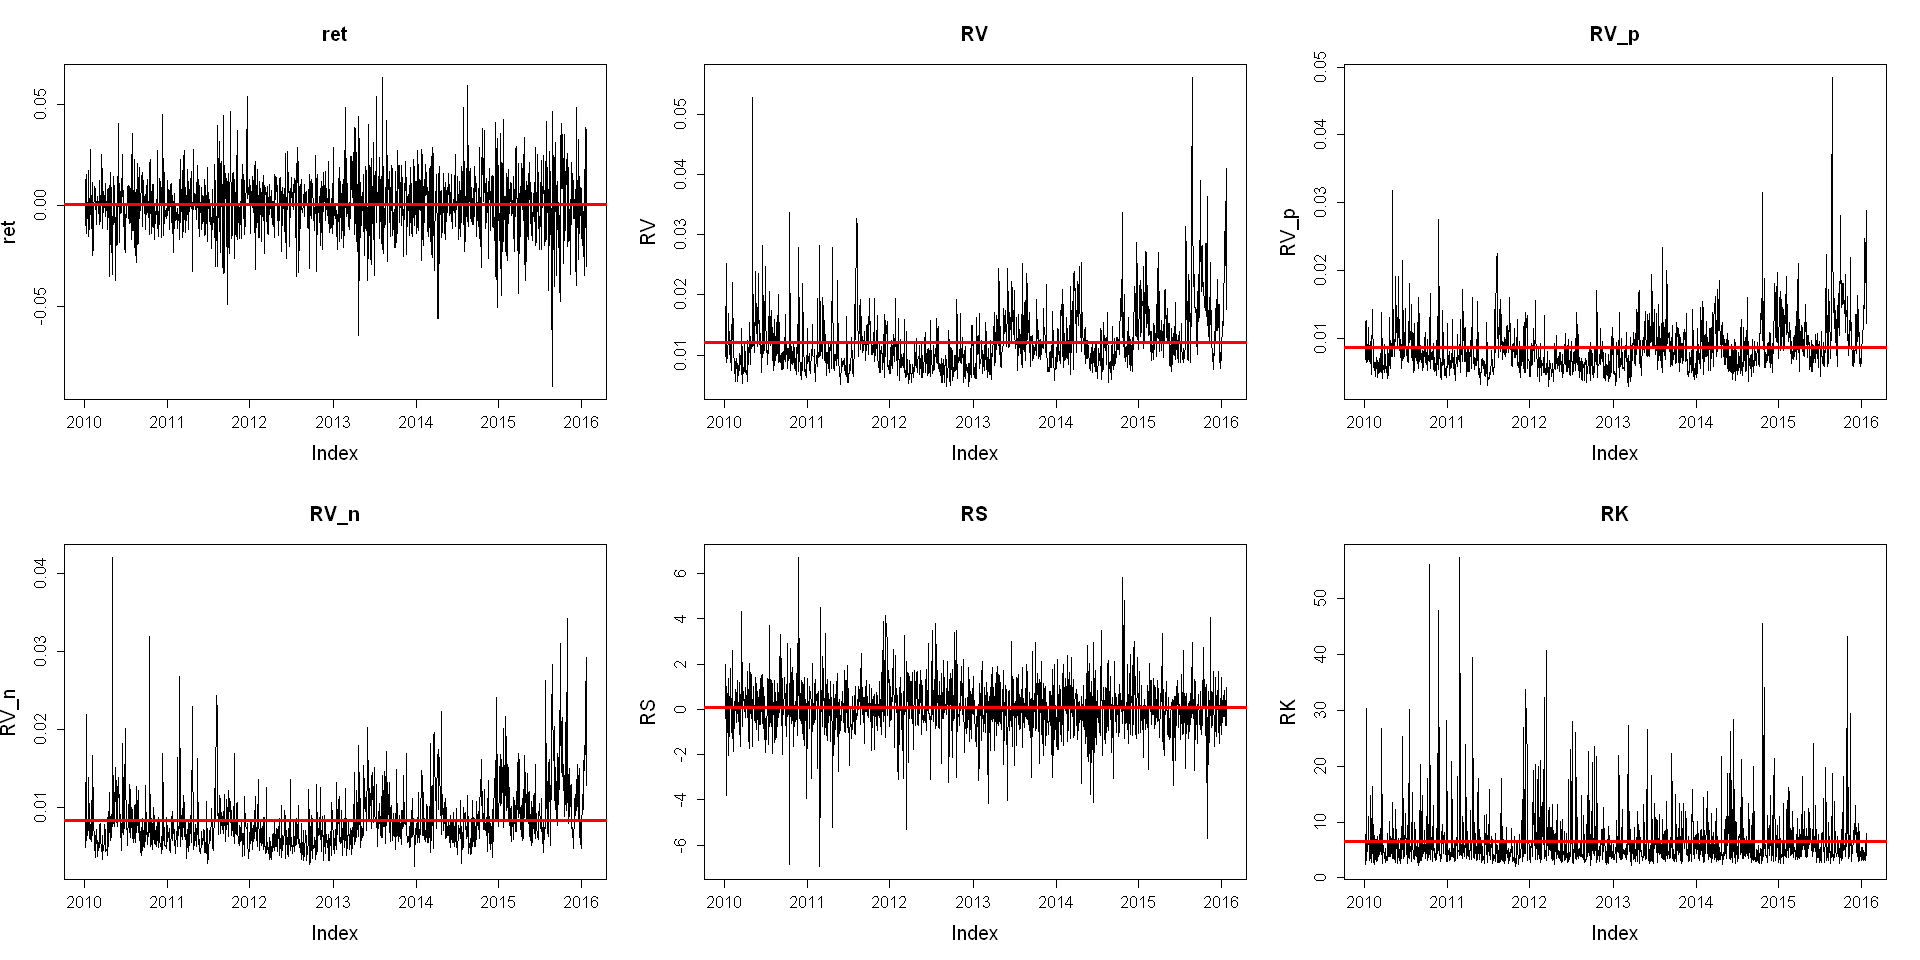

In [6]:
# Change plot dimensions
options(repr.plot.width = 16, repr.plot.height = 8)
# Increase text size
par(cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
par(mfrow = c(2, 3))
for (i in colnames(amgn)) {
  plot.zoo(amgn[, i], main = i, ylab = i)
  abline(h = mean(amgn[, i]), col = "red", lwd = 3)
}
par(mfrow = c(1, 1))

In the figure above, we may observe the plots of all the variables in the dataset, namely:
- returns (ret)
- realized volatility (RV)
- positive realized semi-volatility (RV_p)
- negative realized semi-volatility (RV_n)
- realized skewness (RS)
- realized kurtosis (RK)

The red horizontal line represents the mean value of each of the series. Let us briefly comment on some of the things that we are able to infer from this figure.

We see that returns are more or less symmetric around zero apart from huge returns (in absolute value), which seem to be systematically higher in the negative part of the return series. There are some clusters of volatile returns, especially at the end of the sampling period. This increase in volatility can also be seen in the three measures related to realized volatility, as there is a clear uptick at the very end in each of the graphs. Furthermore, except for some issues with variance stationarity, we believe that it is safe to assume that the process generating the returns at least seems to be mean-stationary.

With respect to RV, we see that it is expectedly positive. Although we do not directly test for the presence of jumps in this project, we can speculate that a few might be present in the RV series based on such huge spikes of RV. These are mostly present at the beginning of the sample (around 2010-2012) and at the end of the sample (around 2015-2016). Interestingly, volatility clustering seems to be characteristic of just the aforementioned end of the sampling period.

As for RV_n and RV_p, we see that there seems to be a greater number of jumps for negative semi-variance series, although we do not test for their presence directly. Nevertheless, it also seems that the mean for RV_n series is lower than the mean for RV_p series (below, this will be checked directly).

Finally, there appears to be no clear pattern in the RS and RK series.

### Summary statistics

In [7]:
head(index(amgn))
# => Daily data
summary(amgn)

[1] "2010-01-05" "2010-01-06" "2010-01-07" "2010-01-08" "2010-01-11"
[6] "2010-01-12"

     Index                 ret                   RV          
 Min.   :2010-01-05   Min.   :-0.0898644   Min.   :0.004731  
 1st Qu.:2011-07-04   1st Qu.:-0.0080350   1st Qu.:0.008735  
 Median :2013-01-10   Median : 0.0008227   Median :0.010927  
 Mean   :2013-01-08   Mean   : 0.0007351   Mean   :0.012157  
 3rd Qu.:2014-07-14   3rd Qu.: 0.0094239   3rd Qu.:0.013948  
 Max.   :2016-01-22   Max.   : 0.0635525   Max.   :0.056139  
      RV_p               RV_n                RS                 RK        
 Min.   :0.002807   Min.   :0.002458   Min.   :-6.95335   Min.   : 1.980  
 1st Qu.:0.006125   1st Qu.:0.005865   1st Qu.:-0.57399   1st Qu.: 3.774  
 Median :0.007679   Median :0.007483   Median : 0.04987   Median : 4.985  
 Mean   :0.008573   Mean   :0.008433   Mean   : 0.06038   Mean   : 6.549  
 3rd Qu.:0.010046   3rd Qu.:0.009853   3rd Qu.: 0.69051   3rd Qu.: 7.198  
 Max.   :0.048485   Max.   :0.042064   Max.   : 6.70995   Max.   :57.468  

Firstly, we see that our assumptions based on plots were more or less correct. As such, both mean and median returns are slightly positive. Also, as noted in the previous subsection, RV_p mean is bigger than RV_n mean. Maybe also an interesting fact is that RS is on average positive.

### Histograms

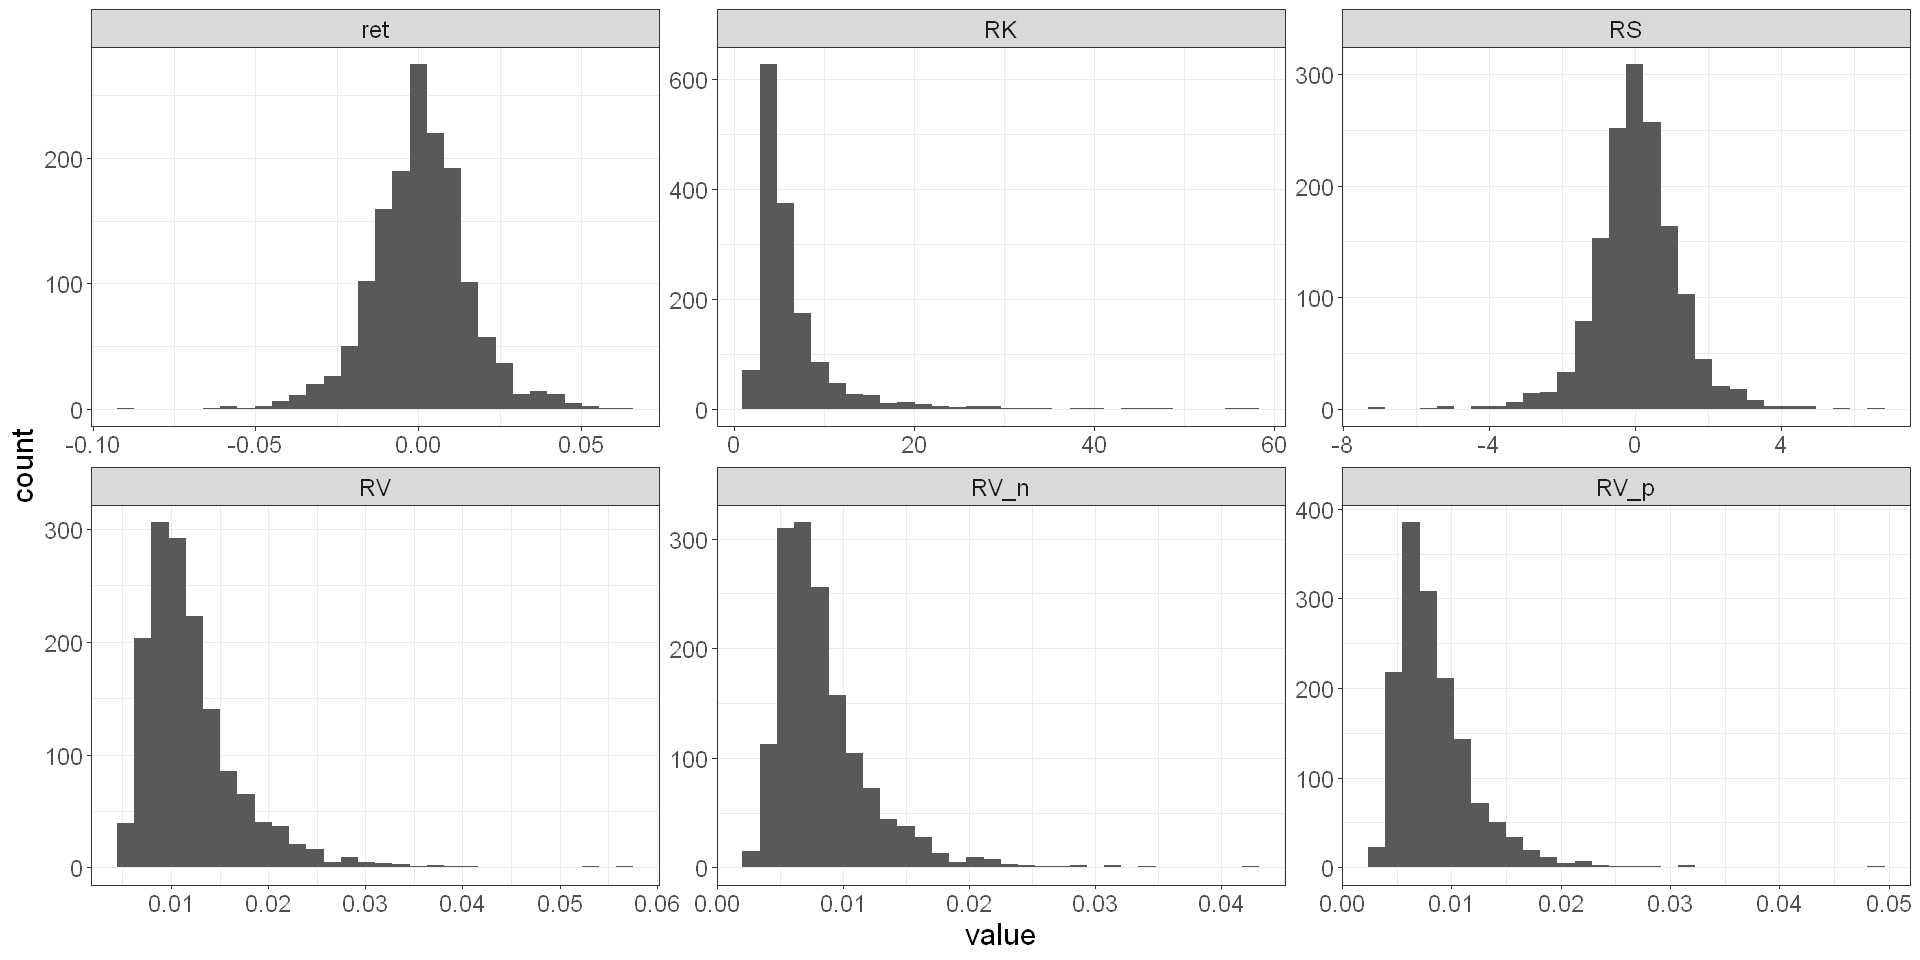

In [8]:
amgn %>%
  as.data.frame() %>%
  gather() %>%
  ggplot(aes(value)) +
  facet_wrap(~key, scales = "free") +
  geom_histogram(bins = 30) +
  theme_bw() +
  theme(text = element_text(size = 18))

Due to their construction, the only variables without a noticeably skewed distribution are returns and realized skewness. Below, we discuss the distribution of returns further.


	Shapiro-Wilk normality test

data:  as.numeric(amgn$ret)
W = 0.97924, p-value = 6.667e-14


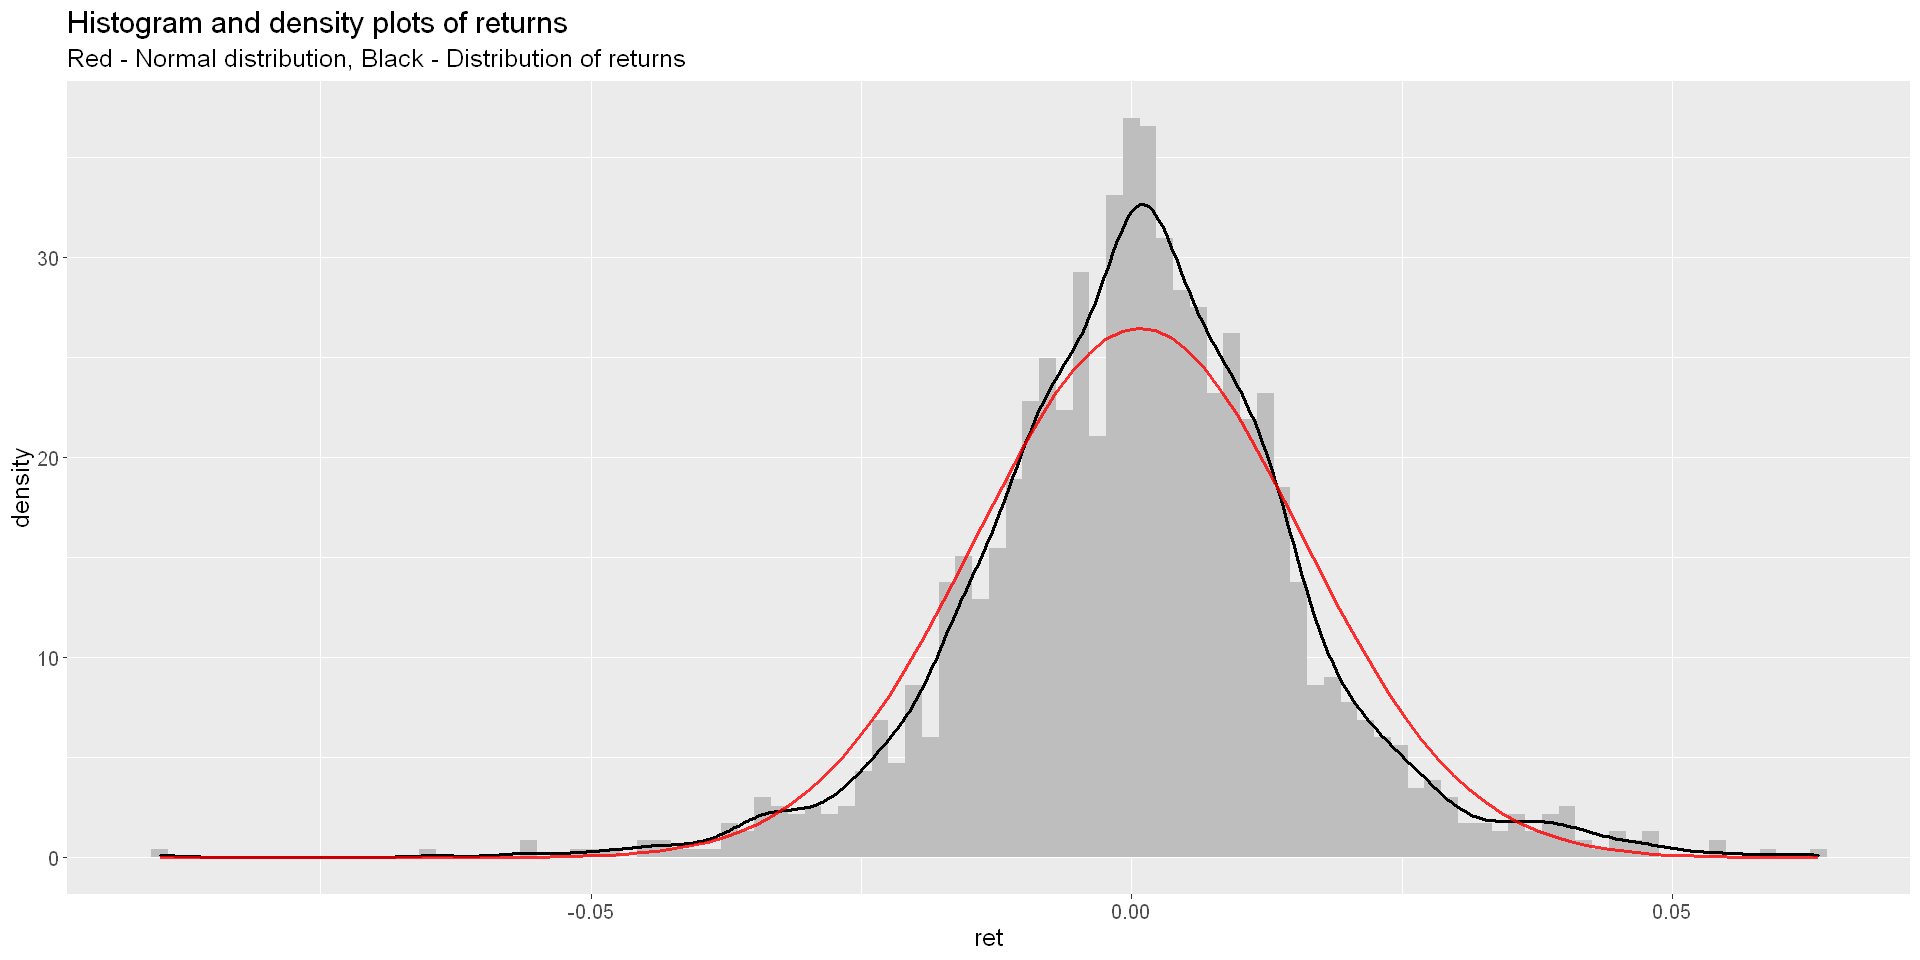

In [9]:
ggplot(amgn, aes(x = ret)) +
    coord_cartesian() +
    geom_histogram(aes(y = ..density..), bins = 100, fill = "gray") +
    # Actual density
    geom_density(alpha = 0.25, size = 1, color = "black") +
    # Theoretical chisquared density
    stat_function(fun = dnorm, args = list(mean = mean(amgn$ret), sd = sd(amgn$ret)), col = "red", size = 1, alpha = 0.8) +
    labs(
        title = "Histogram and density plots of returns",
        subtitle = "Red - Normal distribution, Black - Distribution of returns"
    ) +
    theme(text = element_text(size = 15))

shapiro.test(as.numeric(amgn$ret))

Plotting a more granular histogram with its approximate density (in black) and comparing it with the Gaussian curve (red) reveals more information about the distribution of the amgn returns. Clearly, the distribution of returns is leptokurtic – as indicated by the excess kurtosis and heavier tails. However, other characteristics such as the mean, median, or even skewness, appear to be quite similar to the normal distribution. Regardless, the Shapiro-Wilk test also suggests that returns are not normally distributed.

### Plots of autocorrelation functions

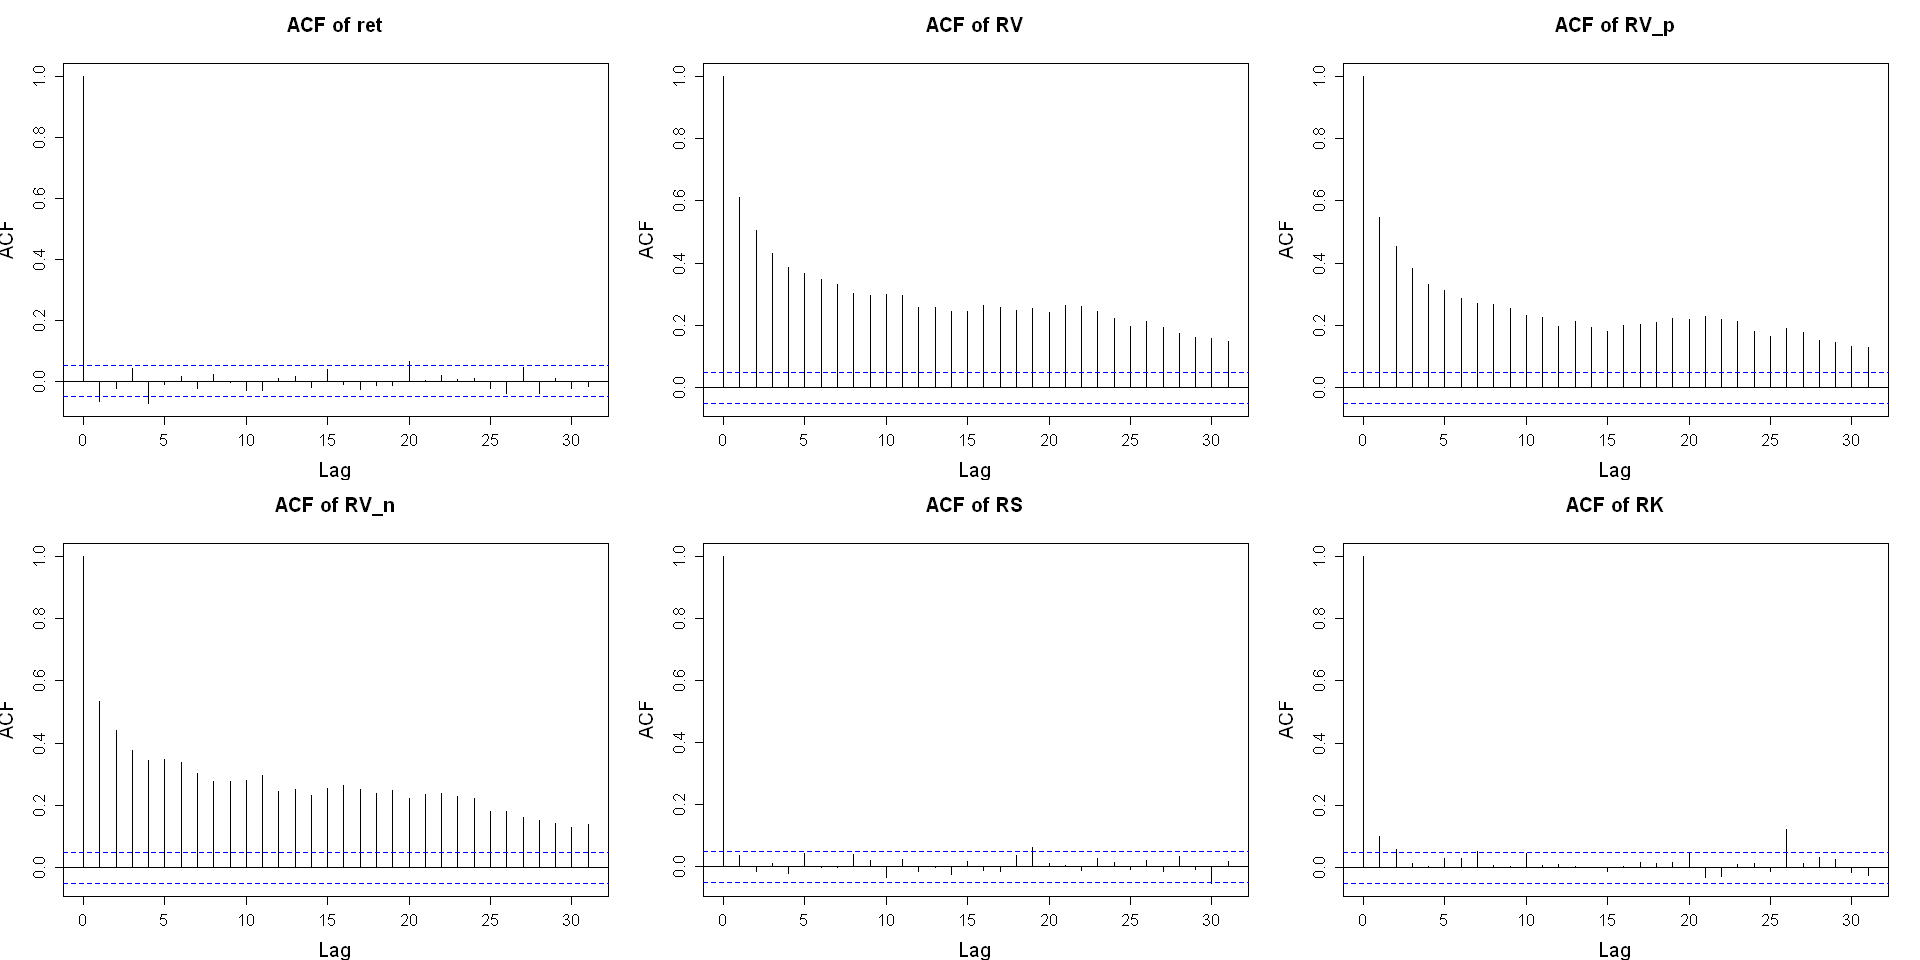

In [10]:
par(mfrow = c(2, 3), mar = c(4, 4, 4, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
for (i in colnames(amgn)) {
  acf(amgn[, i], main = paste("ACF of", colnames(amgn[, i])))
}
par(mfrow = c(1, 1))

Looking at the ACF, we see that the three volatility measures exhibit long-memory properties as their autocorrelations seem to decay relatively slowly. Returns, on the other hand, show essentially no degree of dependence. Finally, there is a similar pattern in the ACF of realized skewness and kurtosis.

We will return to the ACF of returns and its partial variant later.

Let us also comment on the ACF plot of the positive versus negative realized semi-volatility, which can be seen below.

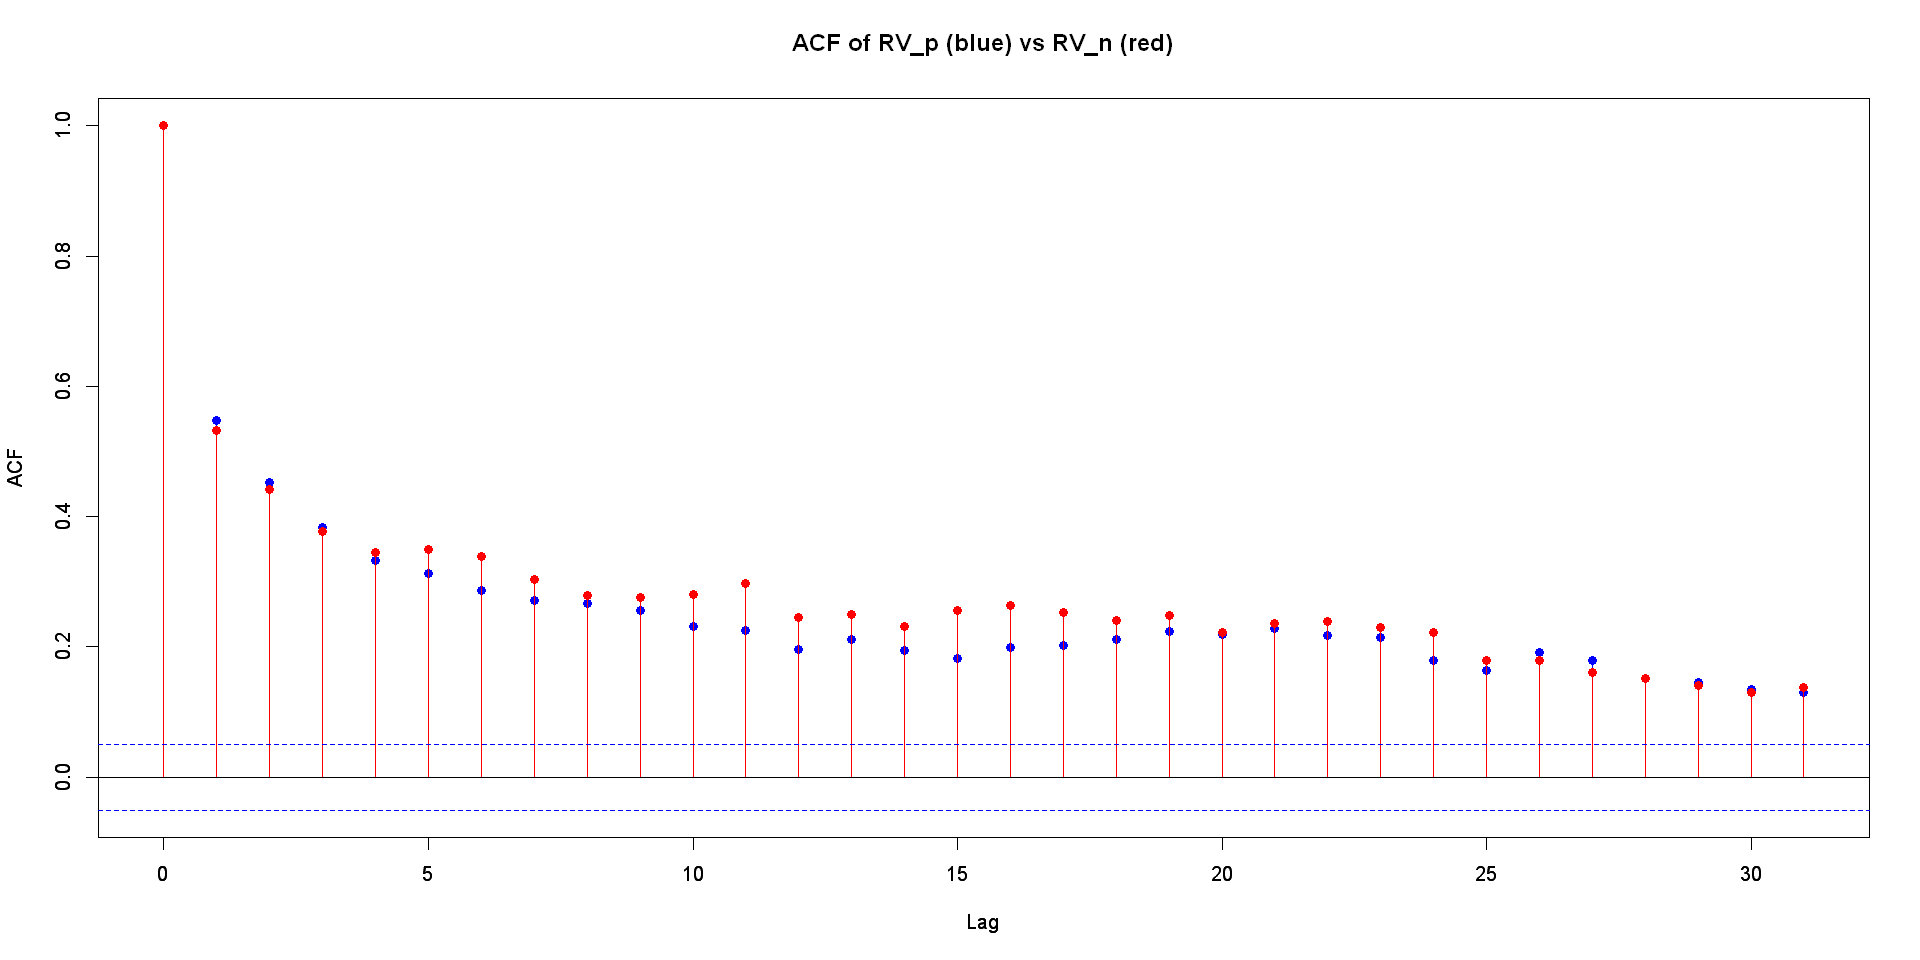

In [11]:
plot(acf(amgn$RV_p, plot = F), type = "h", col = "blue", main = "ACF of RV_p (blue) vs RV_n (red)")
par(new = T)
plot(acf(amgn$RV_p, plot = F), type = "p", col = "blue", pch = 16, main = "")
par(new = T)
plot(acf(amgn$RV_n, plot = F), type = "h", col = "red", main = "")
par(new = T)
plot(acf(amgn$RV_n, plot = F), type = "p", col = "red", pch = 16, main = "")

In some cases, the leverage effect plays a significant role in explaining the outcome variable. In our case, however, we see that, initially, there is almost no difference between the persistence of positive and negative semi-volatility. For further lags, the gap slightly widens between the two, but we think that such a difference cannot be considered significant. All in all, while this does not say much about the presence of the leverage effect in the data or the lack thereof, it perhaps hints at the latter. In other words, based on the ACF plots, it does not seem that negative realized semi-volatility will bring different information to forecasting of realized volatility than positive realized semi-volatility.

# 2. In-sample fit

We continue by estimating six pre-determined volatility models: AR(1), HAR, HAR-RS, HAR-RSkew-RKurt, Realized GARCH, and ARMA-GARCH.

### 2.1 AR(1)-RV

Series: amgn$RV 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
      0.6119  0.0122
s.e.  0.0204  0.0003

sigma^2 = 1.649e-05:  log likelihood = 6131.92
AIC=-12257.84   AICc=-12257.82   BIC=-12241.9

Training set error measures:
                       ME        RMSE         MAE       MPE     MAPE      MASE
Training set 1.914364e-06 0.004058099 0.002734182 -8.373364 22.95539 0.9081488
                   ACF1
Training set -0.1294489

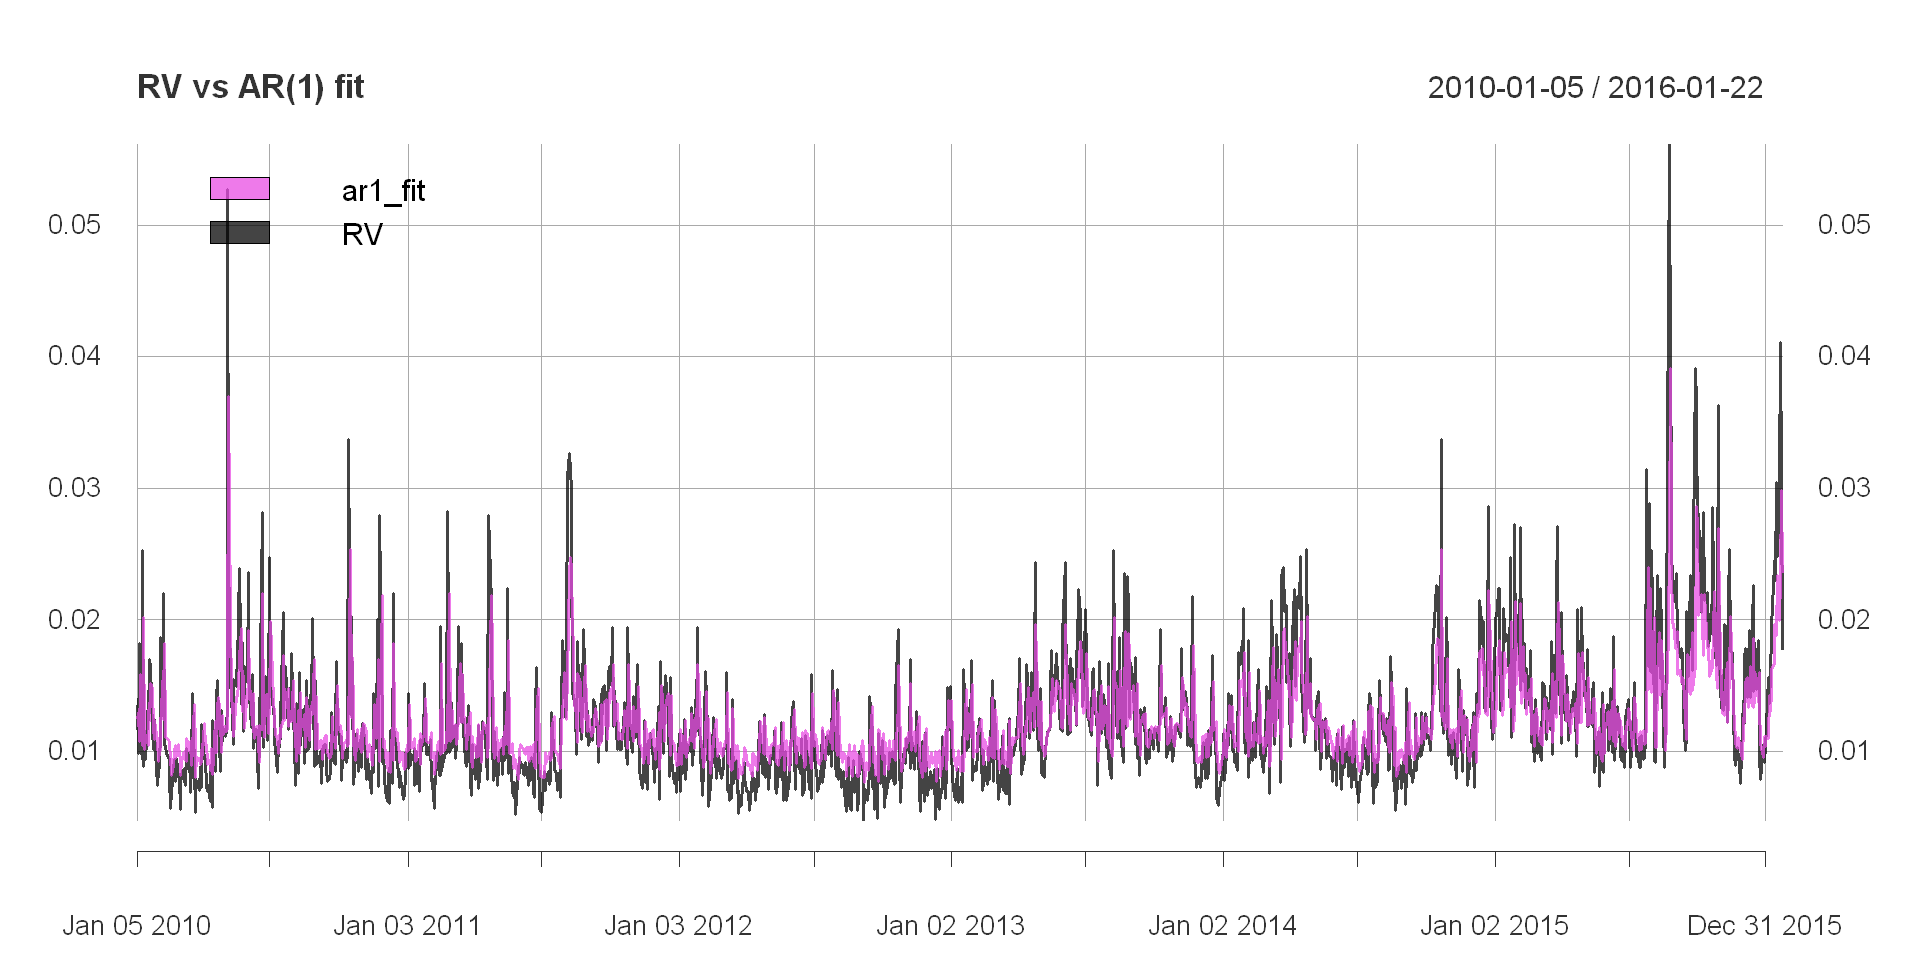

In [12]:
ar1 <- Arima(amgn$RV, order = c(1, 0, 0))
summary(ar1)

ar1_fit <- xts(ar1$fitted, order.by = index(amgn$RV))

plot(
  merge(ar1_fit, amgn$RV),
  main = "RV vs AR(1) fit",
  col = c("#E84AE3BB", "#000000BB"),
  lwd = 3,
  legend.loc = "topleft",
  cex = 1
)


The first model we estimate is an autoregression of order one, which can be written as:

$$
RV_t = \mu + \rho RV_{t-1} + u_t\ \ \ \ \text{for} \ t=1,2,...,T
$$

where $u_t \sim N(0, \sigma^2)$.

The results of the AR(1) model indicate that the first lag's coefficient is positive (0.6) and statistically highly significant. On the other hand, given that RV is empirically quite persistent (motivating the usage of HAR models), 0.6 is small in magnitude when the previous note is taken into account. We suspect that further lags that could be included in the model (similarly to HAR) would be able to capture a higher degree of dependence. Therefore we believe that in-sample fit would be improved after further inclusion of lags.

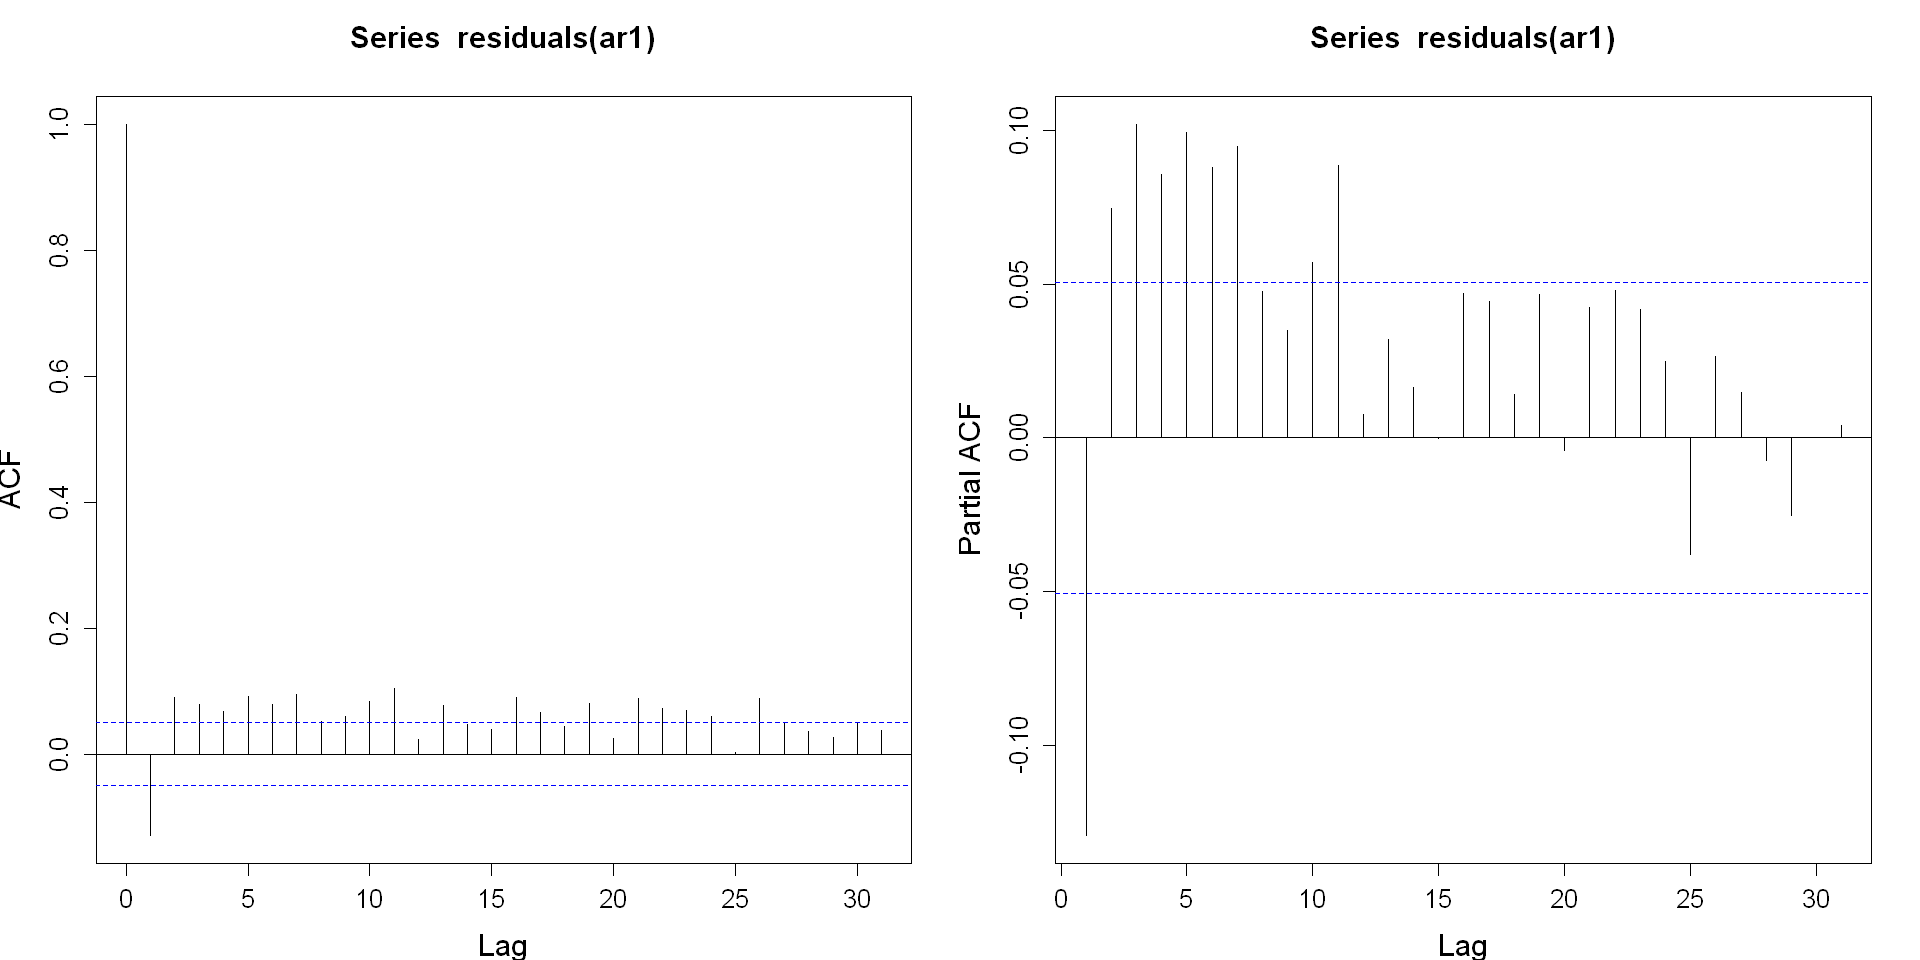

In [13]:
par(mfrow = c(1, 2), mar = c(4, 4, 4, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
acf(residuals(ar1))
pacf(residuals(ar1))
par(mfrow = c(1, 1))

The final assertion in the last paragraph is further corroborated by the ACF and PACF plots of the residuals. It is clear that there is still a substantial degree of dependence left unexplained in the residuals, especially if we look at the PACF plot.

### 2.2 HAR


In [14]:
TT <- length(amgn$RV)
RV5 <- unlist(
  lapply(
    lapply(1:(TT - 4), function(t) {
      return(amgn$RV[t:(t + 4)])
    }),
    mean
  )
)
RV22 <- unlist(
  lapply(
    lapply(1:(TT - 21), function(t) {
      return(amgn$RV[t:(t + 21)])
    }),
    mean
  )
)
T5 <- length(RV5)
T22 <- length(RV22)
har_data <- as.data.frame(
  cbind(
    as.numeric(amgn$RV[23:TT]),
    as.numeric(amgn$RV[22:(TT - 1)]),
    RV5[18:(T5 - 1)],
    RV22[1:(T22 - 1)],
    as.numeric(amgn$RV_n[22:(TT - 1)]),
    as.numeric(amgn$RV_p[22:(TT - 1)]),
    as.numeric(amgn$RK[22:(TT - 1)]),
    as.numeric(amgn$RS[22:(TT - 1)])
  )
)
colnames(har_data) <- c("rv_t0", "rv_t1", "rv5", "rv22", "rvn", "rvp", "rk", "rs")
har_data_ts <- ts(har_data)


Call:
tslm(formula = rv_t0 ~ rv_t1 + rv5 + rv22, data = har_data_ts)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.009147 -0.002274 -0.000662  0.001298  0.040573 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0014888  0.0004001   3.721 0.000206 ***
rv_t1       0.3927004  0.0300351  13.075  < 2e-16 ***
rv5         0.2275188  0.0500134   4.549 5.83e-06 ***
rv22        0.2600405  0.0508486   5.114 3.57e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003885 on 1474 degrees of freedom
Multiple R-squared:  0.4319,	Adjusted R-squared:  0.4308 
F-statistic: 373.6 on 3 and 1474 DF,  p-value: < 2.2e-16


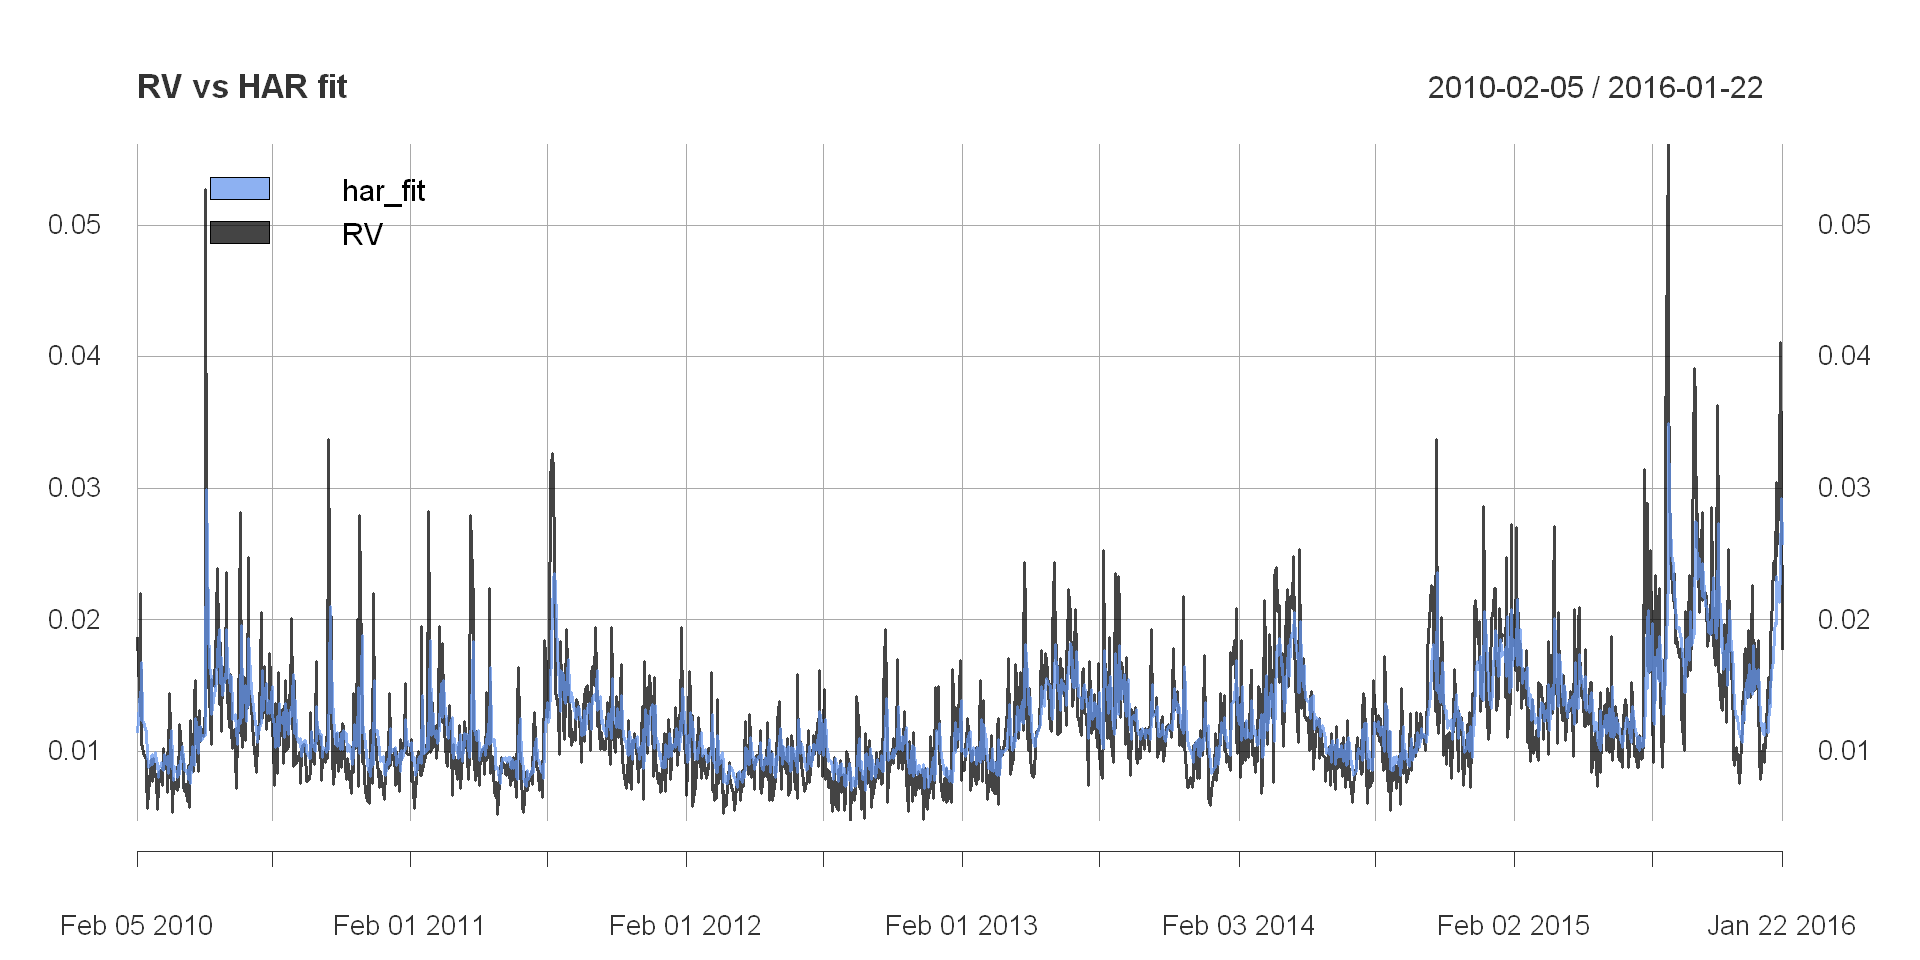

In [15]:
har <- tslm(rv_t0 ~ rv_t1 + rv5 + rv22, data = har_data_ts)
summary(har)

har_fit <- xts(fitted(har), order.by = index(amgn$RV[23:TT]))

plot(
  merge(har_fit, amgn$RV[23:TT]),
  main = "RV vs HAR fit",
  col = c("#6495EDBB", "#000000BB"),
  lwd = 3,
  legend.loc = "topleft",
  cex = 1
)

The motivation behind the HAR model is to capture the *behavior* of heterogeneous traders without estimating an absurdly high number of coefficients. The model takes on the following form:

$$
RV_t = \beta_0 + \beta_1 RV_{t-1} + \beta_2RV_{t-1}^{(5)} + \beta_3RV_{t-1}^{(22)} + u_t\ \ \ \ \text{for} \ t=1,2,...,T
$$

where $RV_{t-1}^{(5)}$ and $RV_{t-1}^{(22)}$ are average weekly and monthly RVs, respectively, and $u_t\sim N(0, \sigma^2)$.

We see that the first lag is the most economically significant coefficient out of all three (nearly equal to 0.4). Coefficients representing weekly and monthly effects are both economically and statistically significant as well. However, the monthly coefficient is more economically significant than the weekly coefficient (though the standard errors overlap). Such a result indicates that investors probably trade the amgn stock more on a monthly rather than weekly basis.

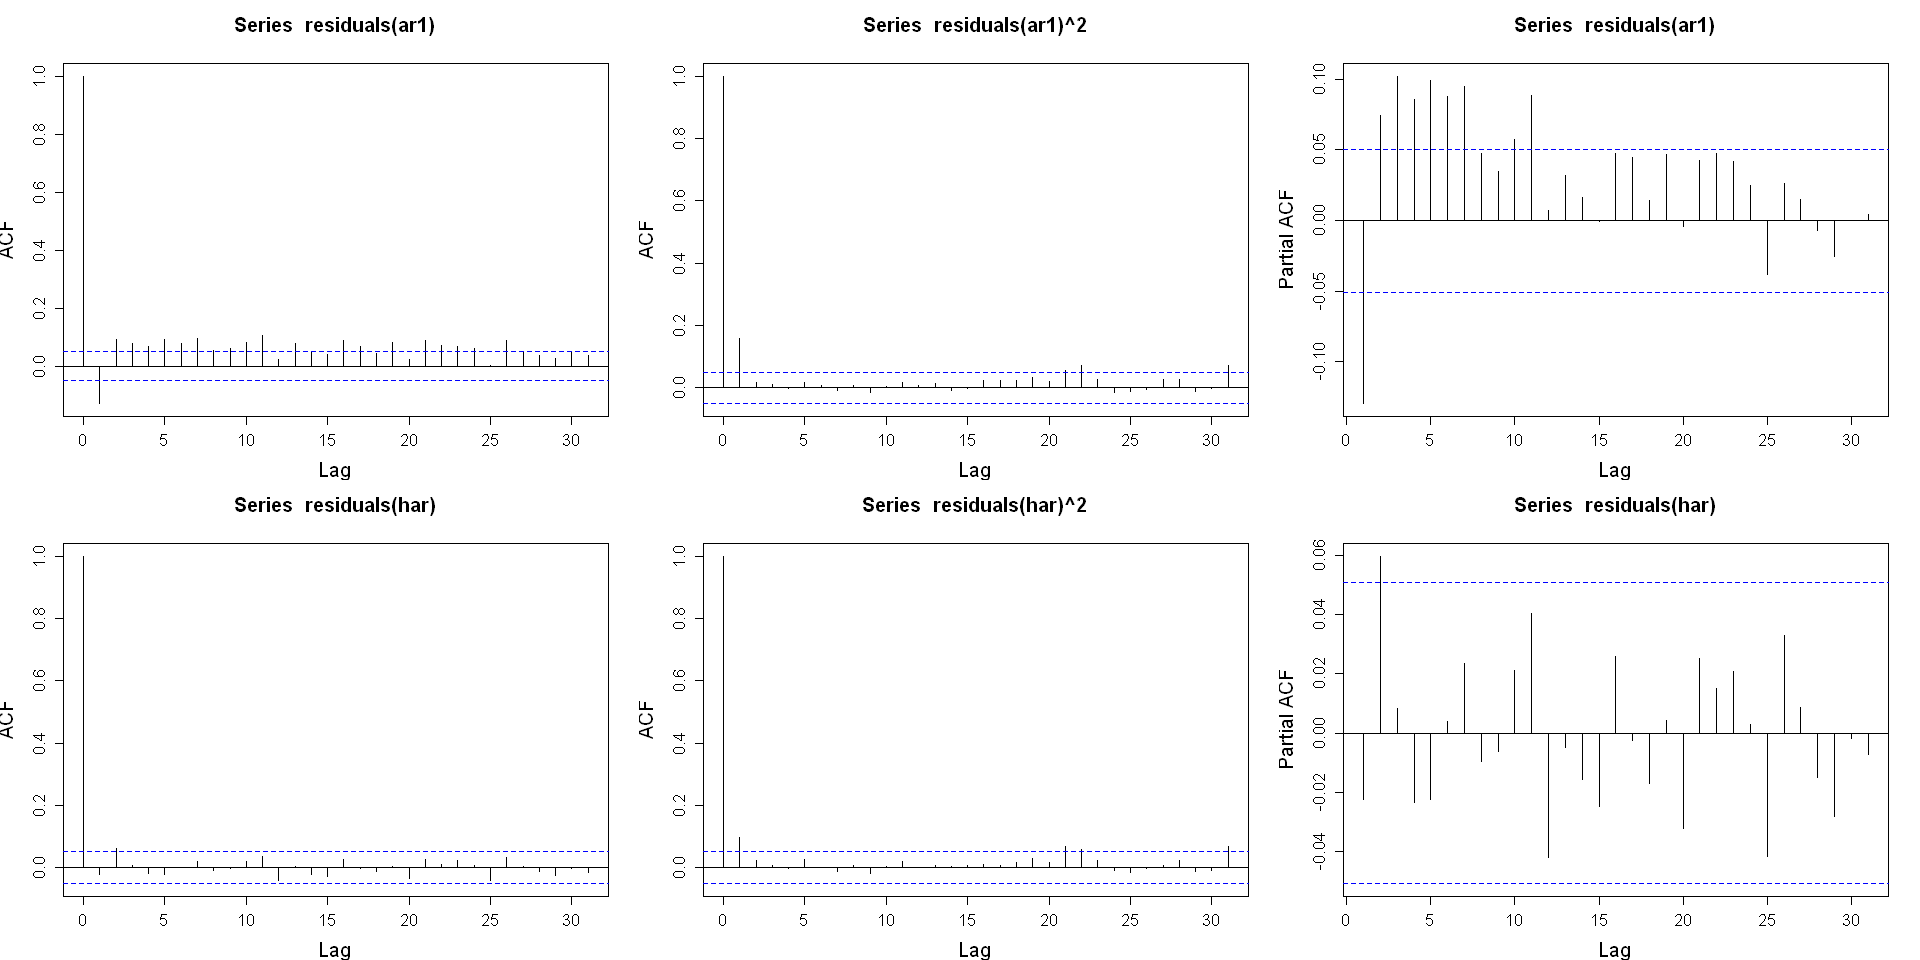

In [16]:
par(mfrow = c(2, 3), mar = c(4, 4, 4, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
acf(residuals(ar1))
acf(residuals(ar1)^2)
pacf(residuals(ar1))
acf(residuals(har))
acf(residuals(har)^2)
pacf(residuals(har))
par(mfrow = c(1, 1))

Comparing the ACFs and PACFs of the AR (top) and HAR (bottom) models, it is clear that the HAR model is much more successful at capturing the relationship, as there appears to be very little dependence left in the residuals.

### 2.3 HAR-RS


Call:
tslm(formula = rv_t0 ~ rvn + rvp + rv5 + rv22, data = har_data_ts)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.009570 -0.002265 -0.000651  0.001270  0.040331 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0015398  0.0003993   3.856  0.00012 ***
rvn         0.3552331  0.0402508   8.826  < 2e-16 ***
rvp         0.2274587  0.0420684   5.407 7.47e-08 ***
rv5         0.2199364  0.0503291   4.370 1.33e-05 ***
rv22        0.2492801  0.0508413   4.903 1.05e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003871 on 1473 degrees of freedom
Multiple R-squared:  0.4362,	Adjusted R-squared:  0.4347 
F-statistic: 284.9 on 4 and 1473 DF,  p-value: < 2.2e-16


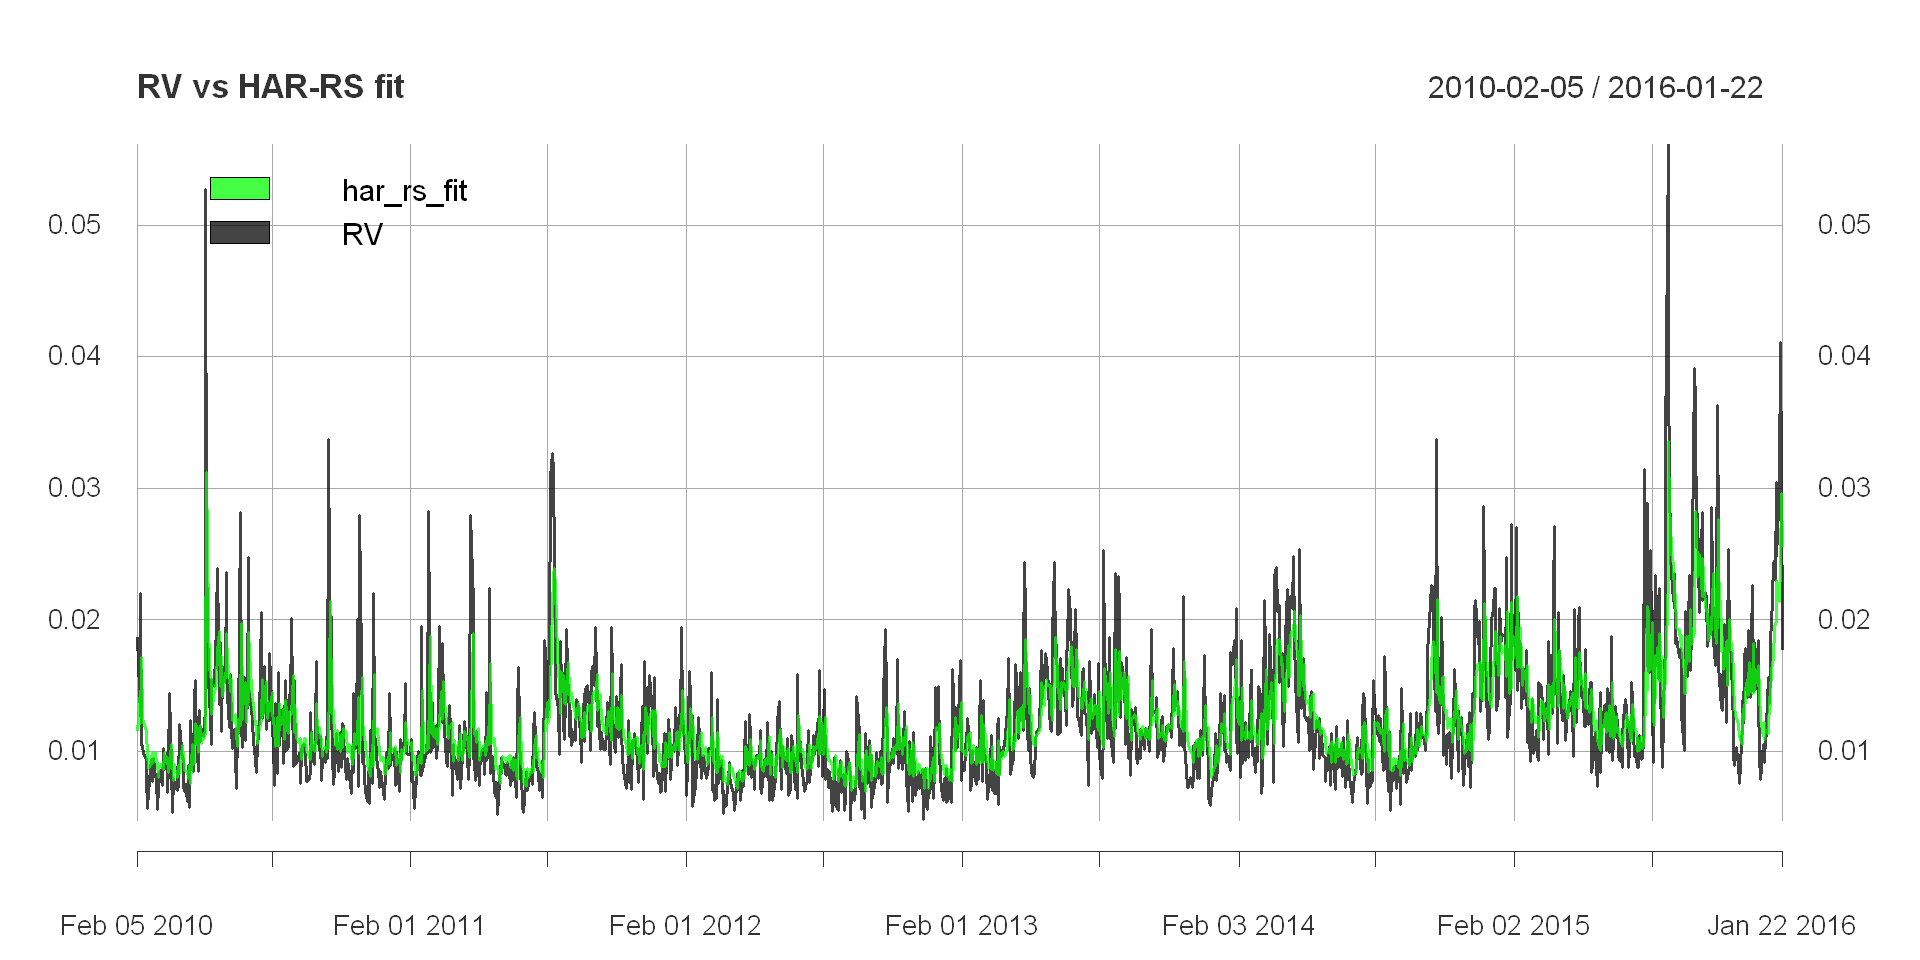

In [17]:
har_rs <- tslm(rv_t0 ~ rvn + rvp + rv5 + rv22, data = har_data_ts)

summary(har_rs)

har_rs_fit <- xts(fitted(har_rs), order.by = index(amgn$RV[23:TT]))

plot(
  merge(har_rs_fit, amgn$RV[23:TT]),
  main = "RV vs HAR-RS fit",
  col = c("#00FF00BB", "#000000BB"),
  lwd = 3,
  legend.loc = "topleft",
  cex = 1
)

The HAR-RS model splits the effect of RV into positive and negative semi-volatility, resulting in the following equation:

$$
RV_t = \beta_0 + \beta_1^+RS^+_{t-1} + \beta_1^-RS^-_{t-1} + \beta_2RV_{t-1}^{(5)} + \beta_3RV_{t-1}^{(22)} + u_t\ \ \ \ \text{for} \ t=1,2,...,T
$$

When we split the effect of the first lag of RV into positive and negative semi-volatility, we obtain different estimates for both of these measures. With respect to the results, we can safely assume that they are not the same given that just the negative semi-volatility's coefficient is almost the same in magnitude as the coefficient of $RV_{t-1}$ in the previous model, and the standard errors are quite low.

We see that the coefficient for RV_n seems to be more economically significant than the coefficient for RV_p. To test this assertion, we run a similar regression below – the difference is that we add an interaction term, which takes the difference between the two semi-volatilities. The idea is that if this difference is not statistically different from zero, then there is no leverage effect present.

With respect to weekly and monthly coefficients, these are more or less the same (both economically and statistically) as in the standard HAR. Furthermore, both R-squared and adjusted R-squared increased at least marginally compared to the standard HAR.

In [18]:
har_rs_test <- tslm(rv_t0 ~ I(rvn - rvp) + rv5 + rv22, data = har_data_ts)
summary(har_rs_test)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.001770078,0.0004220798,4.193704,2.907840e-05
I(rvn - rvp),0.086636905,0.0368501814,2.351058,1.885123e-02
rv5,0.626810236,0.0423059186,14.816136,2.108127e-46
rv22,0.232262323,0.0537769943,4.318990,1.672201e-05


As alluded to above, we tested whether the difference between the two coefficients is statistically different from zero. We see that it is (the coefficient of `I(rvn - rvp)` is significant and positive), meaning that the leverage effect is present in our data.

### 2.4 HAR-Rskew-Rkurt


Call:
tslm(formula = rv_t0 ~ rv_t1 + rv5 + rv22 + rk + rs, data = har_data_ts)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.008874 -0.002246 -0.000635  0.001240  0.040912 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.338e-03  4.156e-04   5.625 2.22e-08 ***
rv_t1        4.673e-01  3.186e-02  14.668  < 2e-16 ***
rv5          1.742e-01  5.018e-02   3.471 0.000533 ***
rv22         2.400e-01  5.034e-02   4.768 2.05e-06 ***
rk          -1.317e-04  2.038e-05  -6.464 1.38e-10 ***
rs          -7.566e-05  8.327e-05  -0.909 0.363752    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.003832 on 1472 degrees of freedom
Multiple R-squared:  0.4479,	Adjusted R-squared:  0.446 
F-statistic: 238.8 on 5 and 1472 DF,  p-value: < 2.2e-16


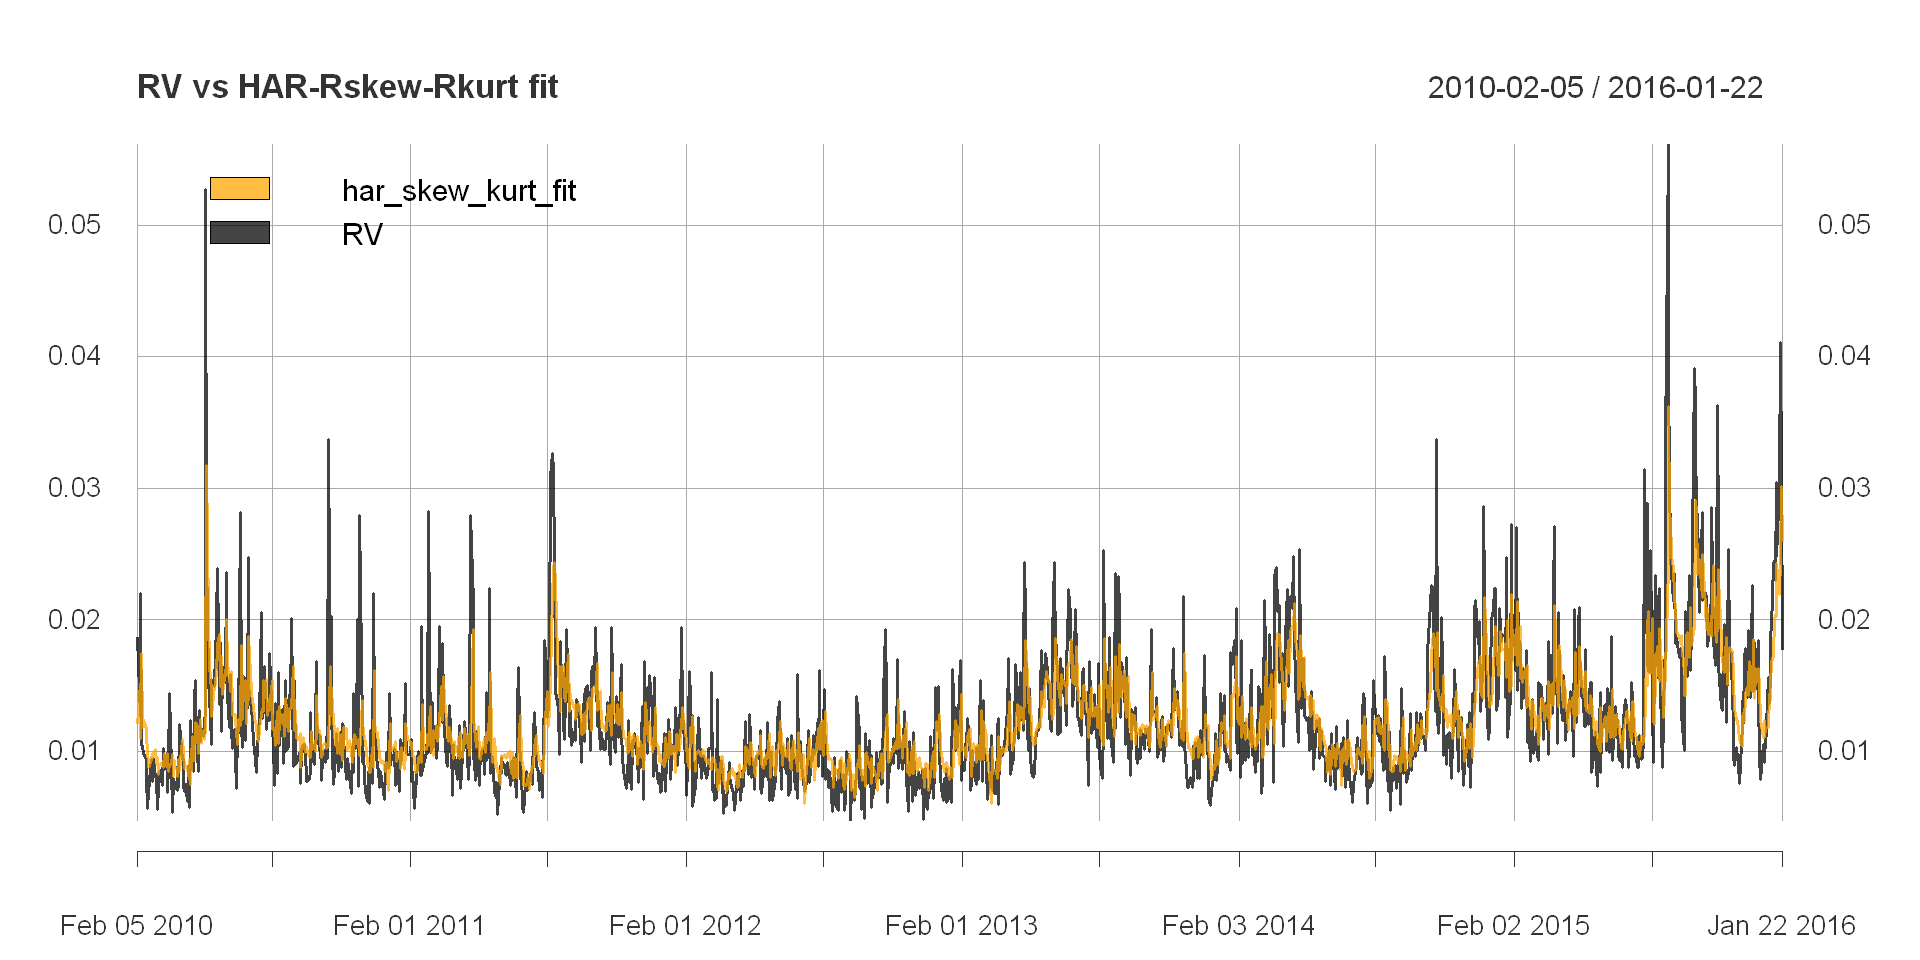

In [19]:
har_skew_kurt <- tslm(rv_t0 ~ rv_t1 + rv5 + rv22 + rk + rs, data = har_data_ts)

summary(har_skew_kurt)

har_skew_kurt_fit <- xts(fitted(har_skew_kurt), order.by = index(amgn$RV[23:TT]))

plot(
  merge(har_skew_kurt_fit, amgn$RV[23:TT]),
  main = "RV vs HAR-Rskew-Rkurt fit",
  col = c("#FFA500BB", "#000000BB"),
  lwd = 3,
  legend.loc = "topleft",
  cex = 1
)

The goal of adding realized skewness and kurtosis to the HAR equation is to account for the effect of jumps. Consequently, the model takes on the following form:

$$
RV_t = \beta_0 + \beta_1RV_{t-1} + \beta_2RV_{t-1}^{(5)} + \beta_3RV_{t-1}^{(22)} + \beta_4RSkew_{t-1} + \beta_5RKurt_{t-1} + u_t \ \ \ \ \text{for} \ t=1,2,...,T
$$

where $u_t \sim N(0,\sigma^2)$, $RSkew_{t}=\sqrt m \frac{\sum^m_{j=1}r^3_{t-1+jn}}{RV_t^{3/2}}$, and $RKurt_{t}=\sqrt m \frac{\sum^m_{j=1}r^4_{t-1+jn}}{RV_t^{2}}$.

We see that the R-squared and adjusted R-squared are the highest in this specification when HAR-family models are considered. The coefficient of $RV_{t-1}$ increased slightly when compared to the classic HAR. Weekly and monthly coefficients slightly decreased economically. Surprisingly, the coefficient for RK is negative and statistically significant. Such results are strange because we would perhaps expect either no relationship or a significantly positive one. On the other hand, the coefficient for RS is insignificant.

### 2.5 Realized GARCH


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: realGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000642    0.000341  1.88430 0.059525
omega  -0.611127    0.206300 -2.96232 0.003053
alpha1  1.000000    0.105245  9.50161 0.000000
beta1   0.667315    0.028934 23.06319 0.000000
eta11  -0.021682    0.003480 -6.23120 0.000000
eta21   0.019499    0.002034  9.58579 0.000000
delta   0.274950    0.022328 12.31414 0.000000
lambda  0.128397    0.002347 54.71666 0.000000
xi      0.117014    0.189948  0.61603 0.537873

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000642    0.000315  2.03419 0.041932
omega  -0.611127    0.238113 -2.56654 0.010272
alpha1  1.000000    0.131318  7.61513 0.000000
beta1

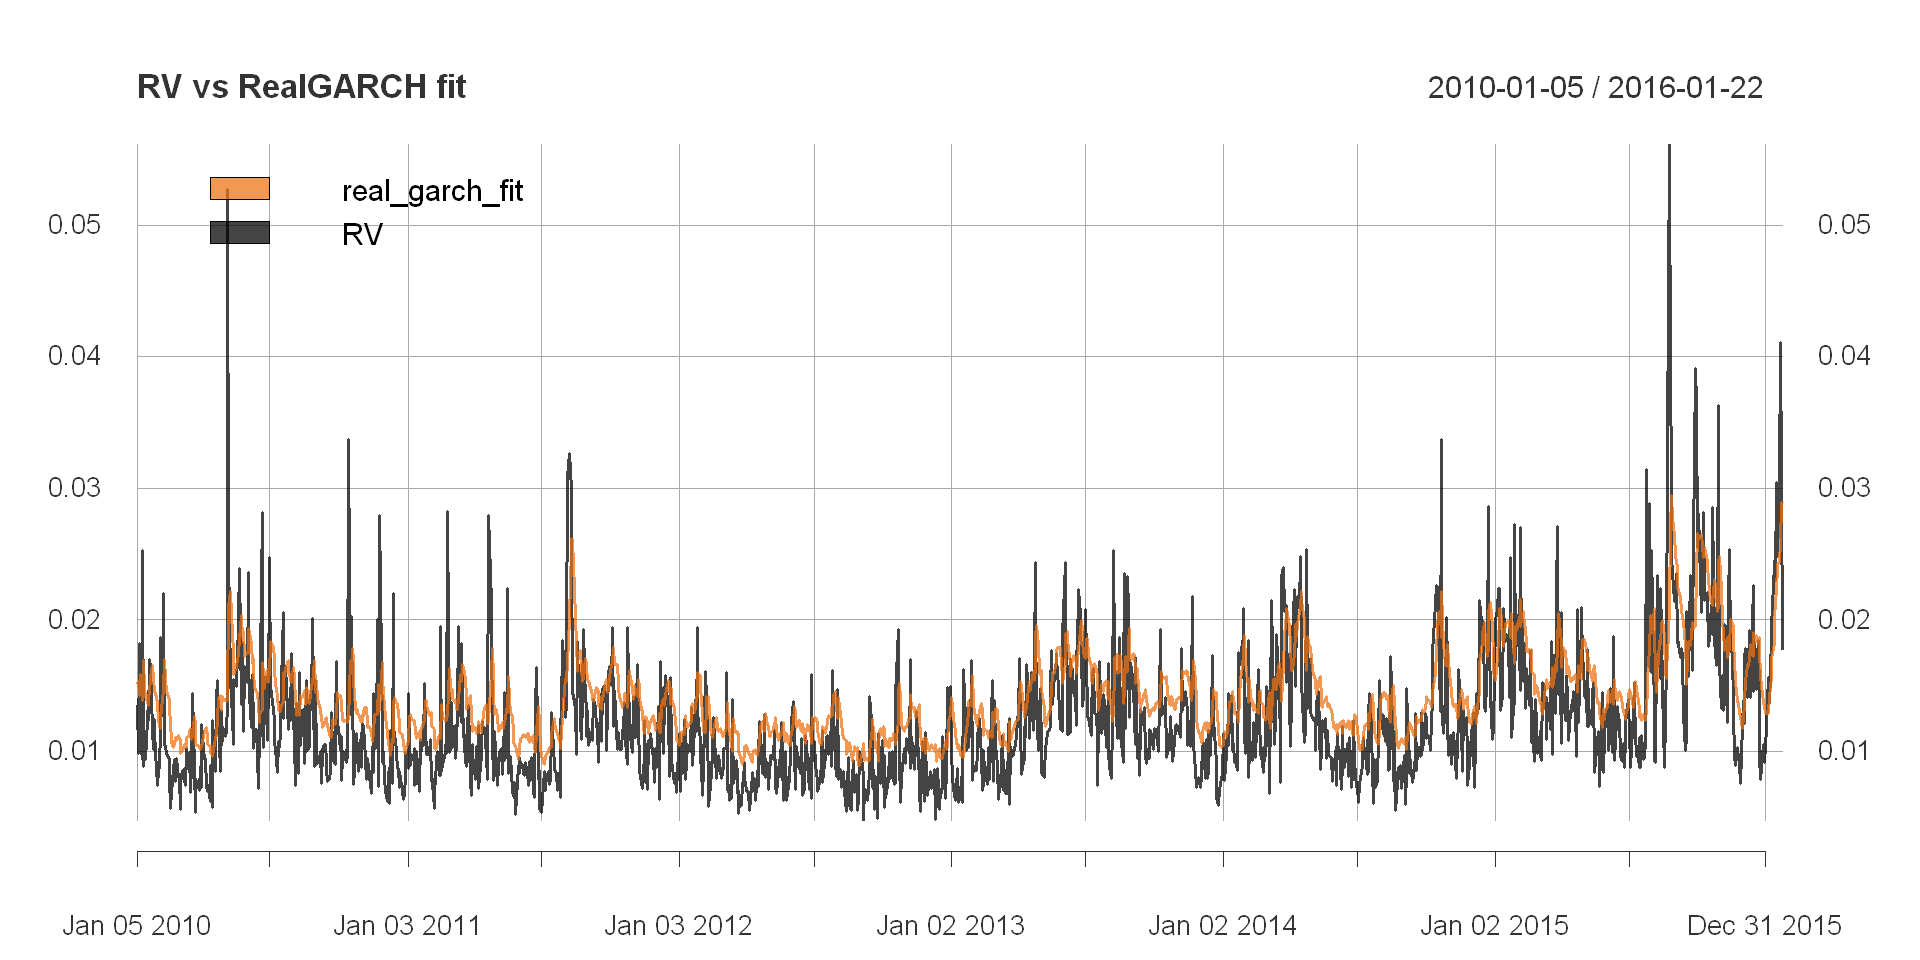

In [20]:
realgarchspec <- ugarchspec(
    variance.model = list(model = "realGARCH", garchOrder = c(1, 1)),
    mean.model = list(armaOrder = c(0, 0), include.mean = TRUE)
)
real_garch <- ugarchfit(
  realgarchspec,
  amgn$ret,
  # "hybrid" did not converge
  solver = "gosolnp",
  realizedVol = sqrt(amgn$RV)
)

real_garch

real_garch_fit <- xts(real_garch@fit$sigma, order.by = index(amgn$RV))

plot(
  merge(real_garch_fit, amgn$RV),
  main = "RV vs RealGARCH fit",
  col = c("#EE7313BB", "#000000BB"),
  lwd = 3,
  legend.loc = "topleft",
  cex = 1
)

Building on the usual GARCH specification, realized GARCH utilizes realized volatility to improve fit. The equation takes on the following form:

$$
\begin{align*}
r_t &= \sqrt{h_t} z_t \\
log(h_t) &= \alpha_0 + \alpha_1 log(x_{t-1}) + \beta_1log(h_{t-1}) \\
log(x_t) &= \xi + \psi log(h_t) + u_t \ \ \ \ \text{for} \ t=1,2,...,T
\end{align*}
$$

where $z_t\sim N(0,1)$, $u_t \sim N(0, \sigma^2)$, and $x_t$ is a realized measure of volatility.

Firstly, let us note that we initially mistakenly included `sqrt(amgn$RV)` as the `realizedVol` parameter in the `ugarchfit` function. However, upon further inspection, including the squared root of realized volatility improved the in-sample fit (as we will cover later in this section), which is the reason why we kept this specification.

When commenting the results of Realized GARCH, we refer only to coefficients of $\alpha_1$ and $\beta_1$ since they represent the effect of log of past $x_t$, and log of past estimated volatility on current estimate of log of current $x_t$, respectively. As such, we see that $\alpha_1$ is very high (extremely close to 1.0) and also statistically very significant. Such result is very similar to that during the seminars. We also see that the $\beta_1$ coefficient is also both economically and statistically significant. This indicates that even though the log volatility estimate reacts quite strongly to the log of past $x_t$, it is perhaps slowed down by the quite high coefficient of log of past volatility.

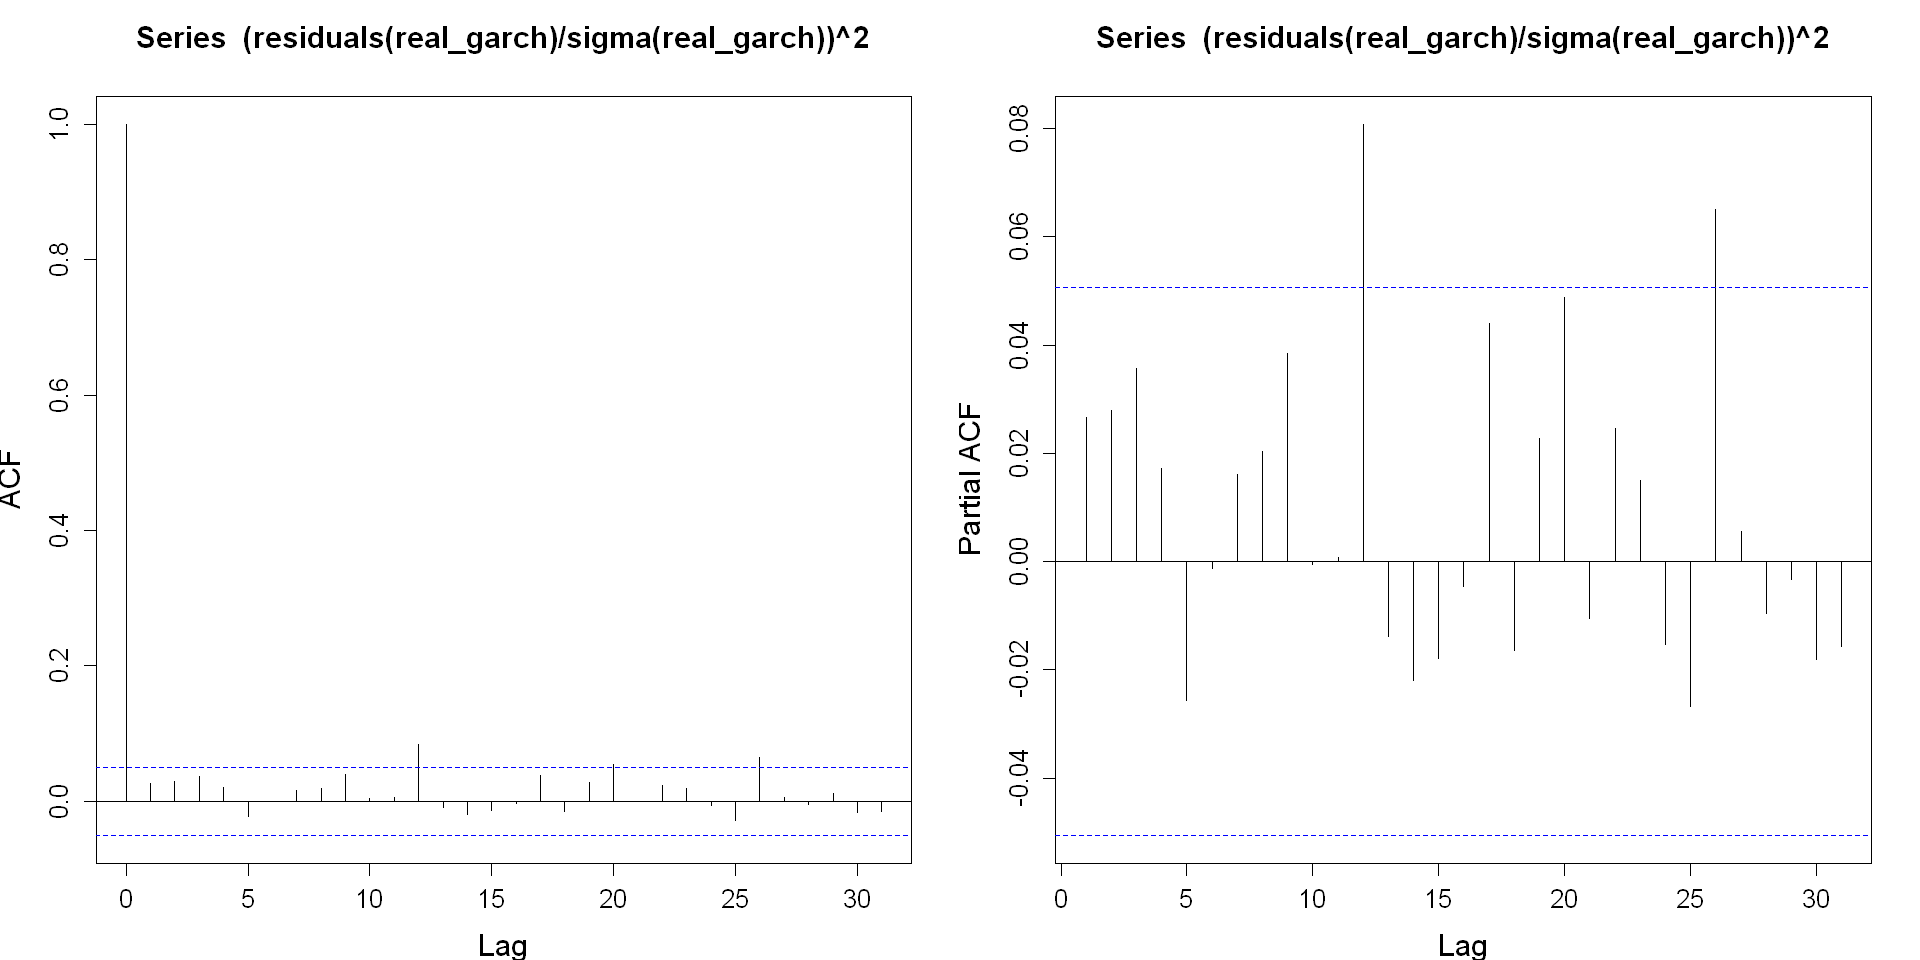

In [21]:
par(mfrow = c(1, 2), mar = c(4, 4, 4, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
acf((residuals(real_garch) / sigma(real_garch))^2)
pacf((residuals(real_garch) / sigma(real_garch))^2)
par(mfrow = c(1, 1))

Finally, the ACF and PACF plots of the model's standardized squared residuals are similar in nature to those observed in the HAR's case. Thus, it could be argued that there is not much dependence left in the residuals. Furthermore, such argument is supported by not rejecting the null hypothesis at any relevant significance level of the Ljung-Box test on standardized squared residuals. On the other hand, the null hypothesis of the Ljung-Box test on standardized residuals was rejected for various number of lags specification.

### 2.6 ARMA-GARCH

Firstly, let us decide on the ARMA order of the mean equation. We will combine information from observing the ACF and PACF of returns with the automated algorithm, which *brute-forces* its way to the *best* specification based on information criteria. The BIC criterion is often considered the strictest, which is why we will mainly focus on it. By setting the `approximation` and `stepwise` arguments to `F`, the function will search through more specifications.

Series: amgn$ret 
ARIMA(0,0,0) with zero mean 

sigma^2 = 0.0002273:  log likelihood = 4163.51
AIC=-8325.03   AICc=-8325.03   BIC=-8319.72

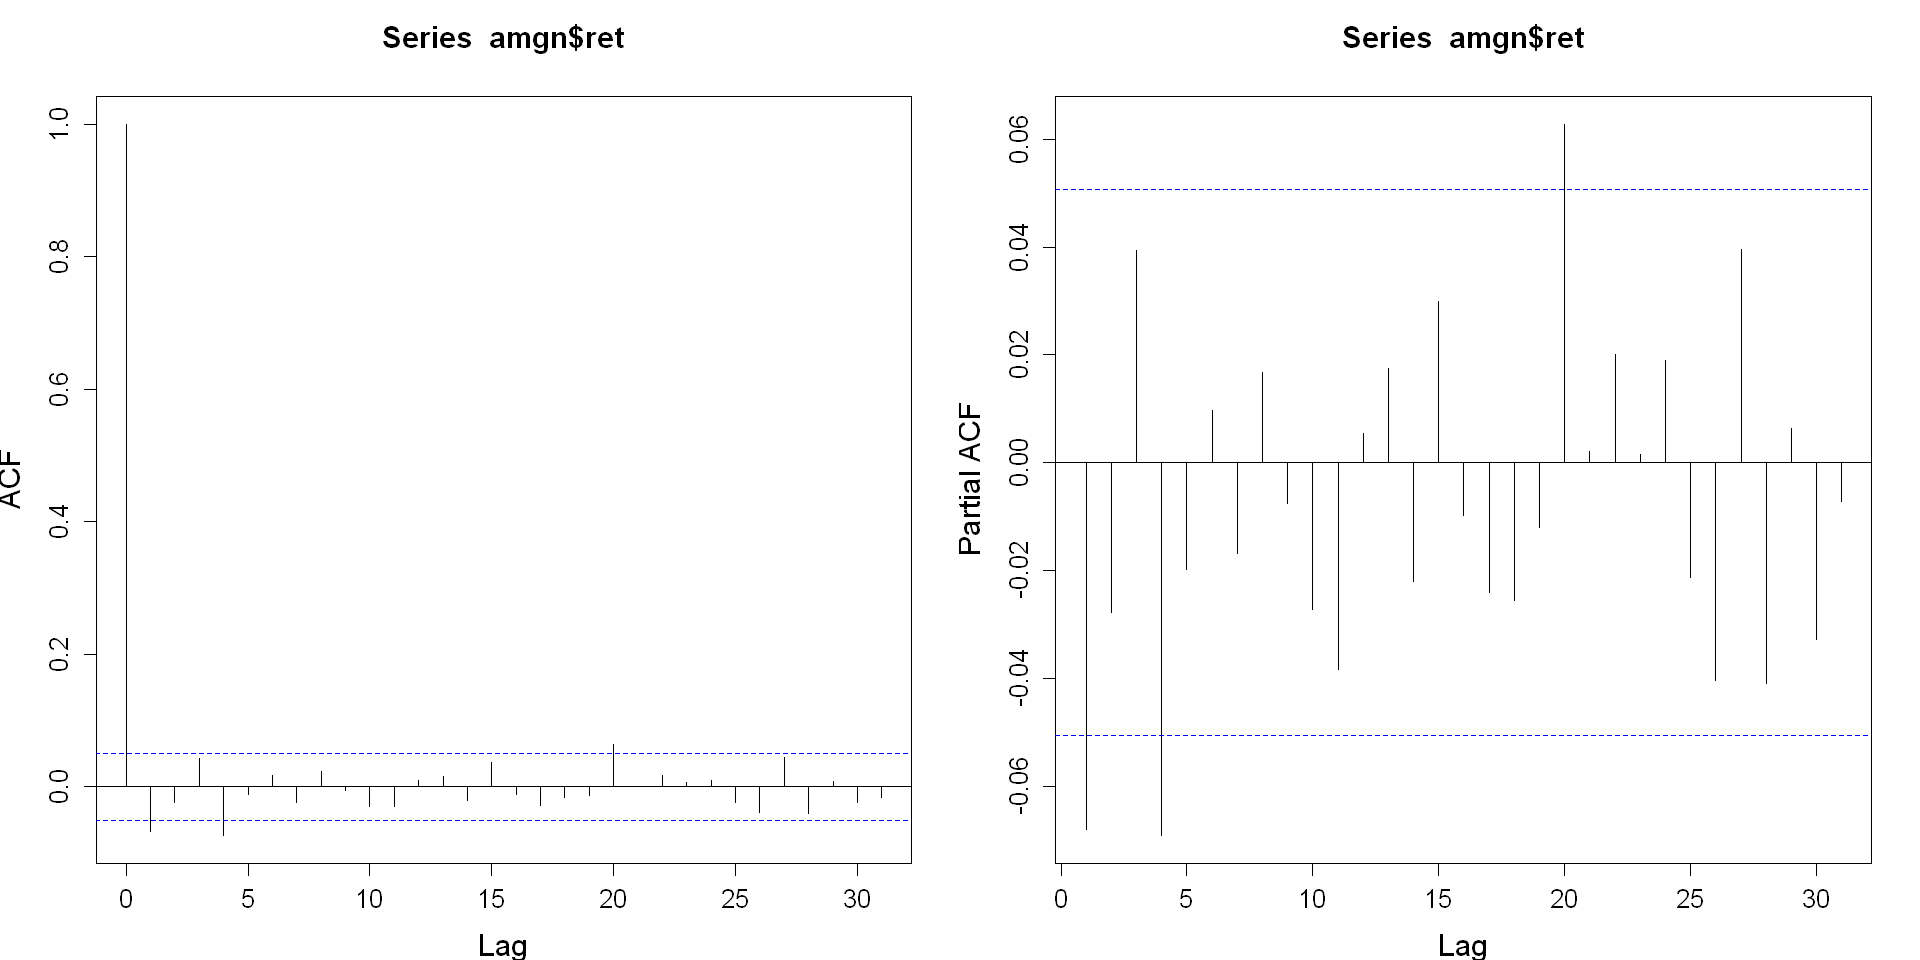

In [22]:
auto.arima(amgn$ret, ic = "bic", stepwise = F, approximation = F)
par(mfrow = c(1, 2), mar = c(4, 4, 4, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
acf(amgn$ret)
pacf(amgn$ret)
par(mfrow = c(1, 1))
# Suggests no AR nor MA terms

While we may find some statistically significant peaks in both the ACF and the PACF (e.g., lag 1), we are not entirely convinced that these would warrant an inclusion of any lagged terms into the mean equation. Similarly, the `auto.arima()` function's output points to the same idea, even excluding the constant term. Furthermore, a $GARCH(1,1)$ specification is commonly used in empirical literature, thus, let us model the variance in this way and decide whether the goodness of fit of the $GARCH(1,1)$ model is satisfactory.


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000010    0.000001   14.584        0
alpha1  0.098862    0.009194   10.753        0
beta1   0.858661    0.013307   64.525        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000010    0.000001  11.4036        0
alpha1  0.098862    0.009993   9.8936        0
beta1   0.858661    0.015134  56.7383        0

LogLikelihood : 4233.469 

Information Criteria
------------------------------------
                    
Akaike       -5.6406
Bayes        -5.6300
Shibata      -5.6406
Hannan-Quinn -5.6367

Weighted Ljung-Box Test on Standardized Residuals
------------------------------------
           

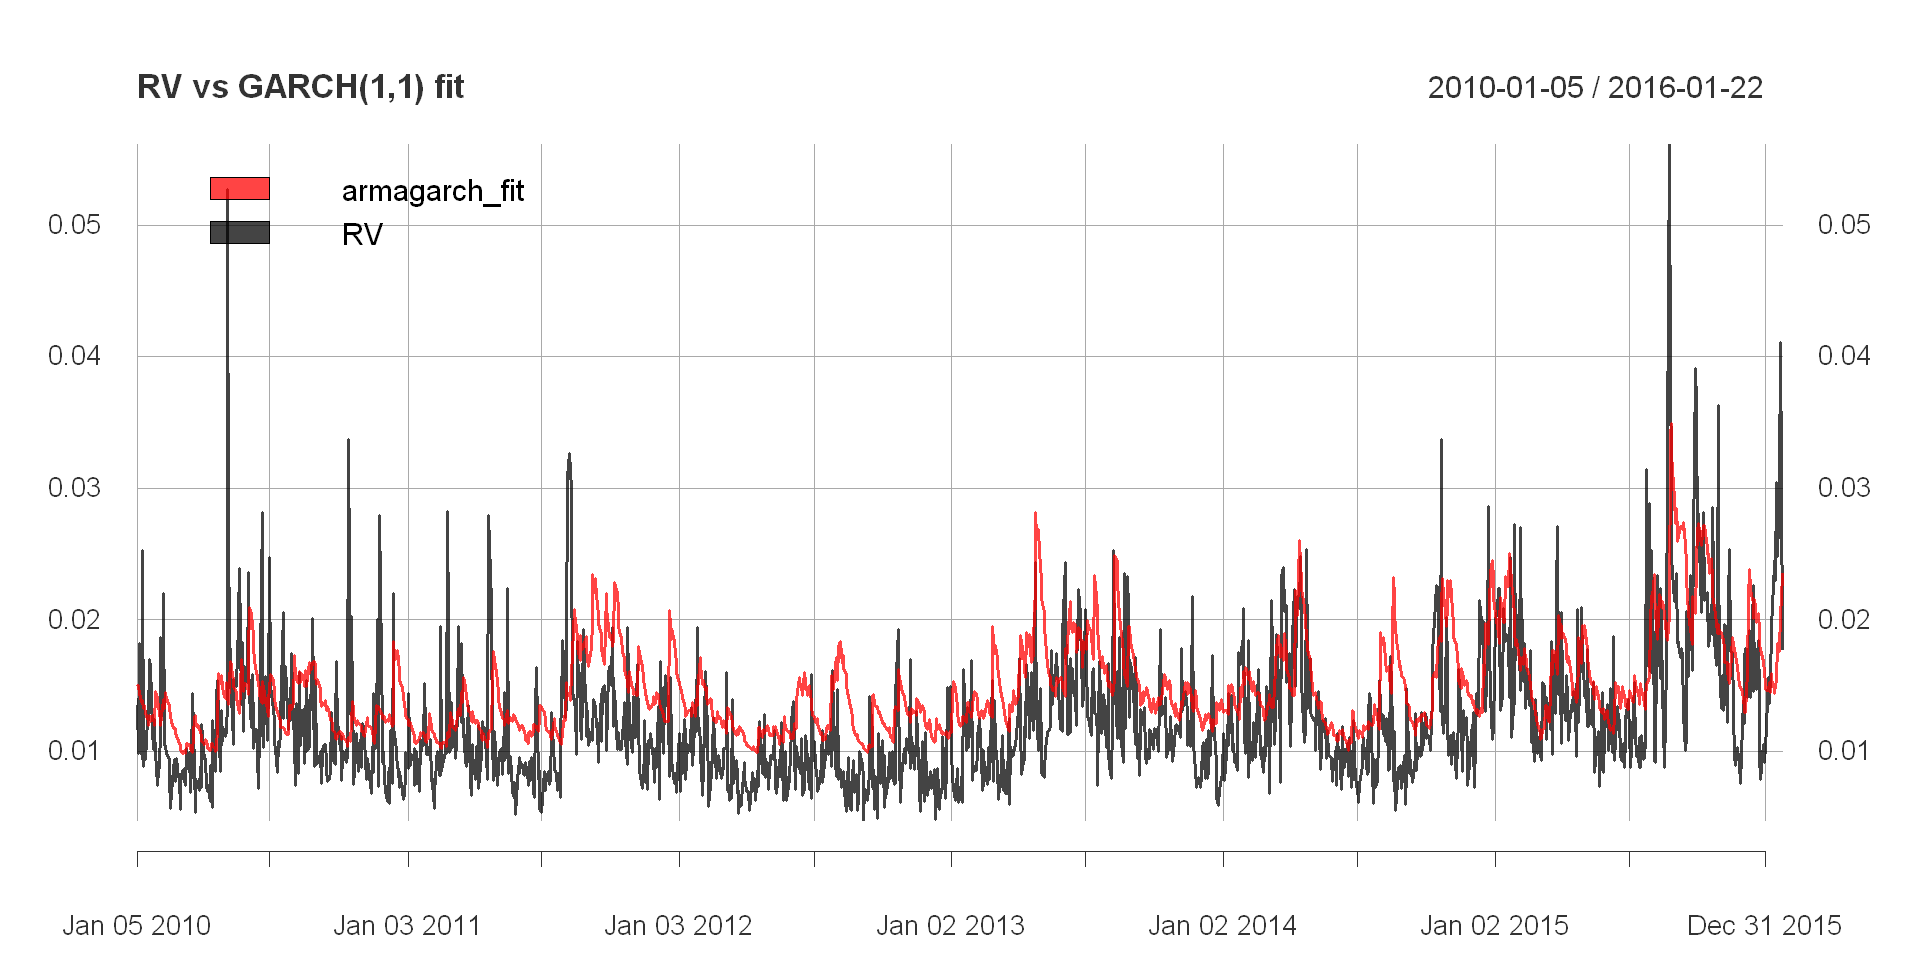

In [23]:
armagarchspec <- ugarchspec(
    variance.model = list(
        garchOrder = c(1, 1)
    ),
    mean.model = list(
        armaOrder = c(0, 0),
        include.mean = F
    )
)

armagarch <- ugarchfit(armagarchspec, amgn$ret)
armagarch

armagarch_fit <- xts(armagarch@fit$sigma, order.by = index(amgn$RV))

plot(
  merge(armagarch_fit, amgn$RV),
  main = "RV vs GARCH(1,1) fit",
  col = c("#FF0000BB", "#000000BB"),
  lwd = 3,
  legend.loc = "topleft",
  cex = 1
)

To reiterate, our ARMA-GARCH model takes on the following form:

$$
\begin{align*}
r_t &= u_t,\ \text{where}\ u_t \sim N(0, \sigma^2_t) \\
\sigma^2_t &= \alpha_0 + \alpha_1 u_{t-1}^2 + \beta_1 \sigma^2_{t-1} \ \ \ \ \text{for} \ t=1,2,...,T
\end{align*}
$$

When looking at the results, they indicate that the process is quite close to being unit-root, since the sum of both alpha and beta almost approaches 1. Maybe it would also make sense to consider an IGARCH specification. To comment on the result, we see that $\beta_1$ has a coefficient of 0.85 and is statistically significant. Such a result indicates quite high volatility clustering and a bit longer memory of volatility. Conversely, the $\alpha_1$ coefficient is quite low (0.10) but statistically significant. In other words, volatility reacts far less significantly to recent movements than past volatility.

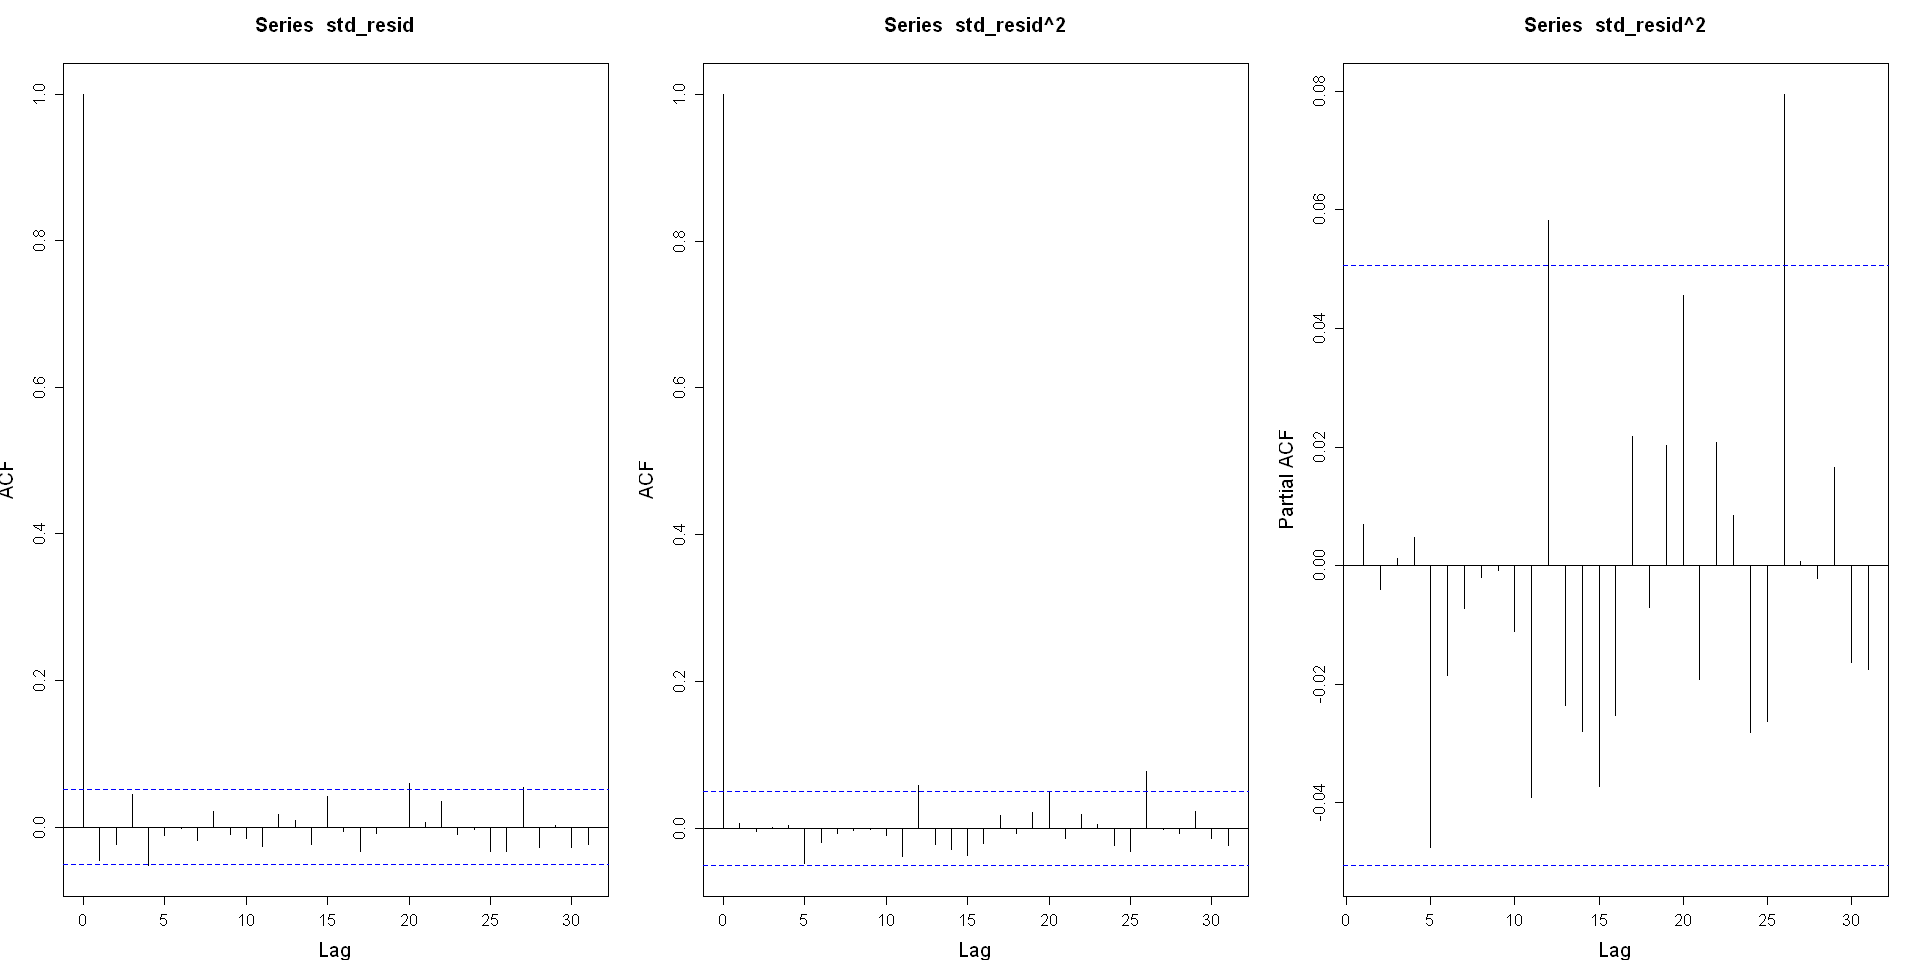

In [24]:
par(mfrow = c(1, 3), mar = c(4, 4, 4, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
std_resid <- residuals(armagarch) / sigma(armagarch)
acf(std_resid)
acf(std_resid^2)
pacf(std_resid^2)
par(mfrow = c(1, 1))

Observing the ACF plots of the standardized residuals together with the PACF, we see that the $ARMA(0,0)-GARCH(1,1)$ model (further referred to as $GARCH(1,1)$ only) is able to remove most of the dependence in the residuals. This is also supported by the Ljung-Box tests, which could be seen in the lengthy text output before.

### 2.7 Comparison

Because overlaying the plots would not generate a useful picture, we plotted the in-sample fits next to each other, duplicating the RV plot for symmetry. Note that the values on the y axis are the same for all fitted values.

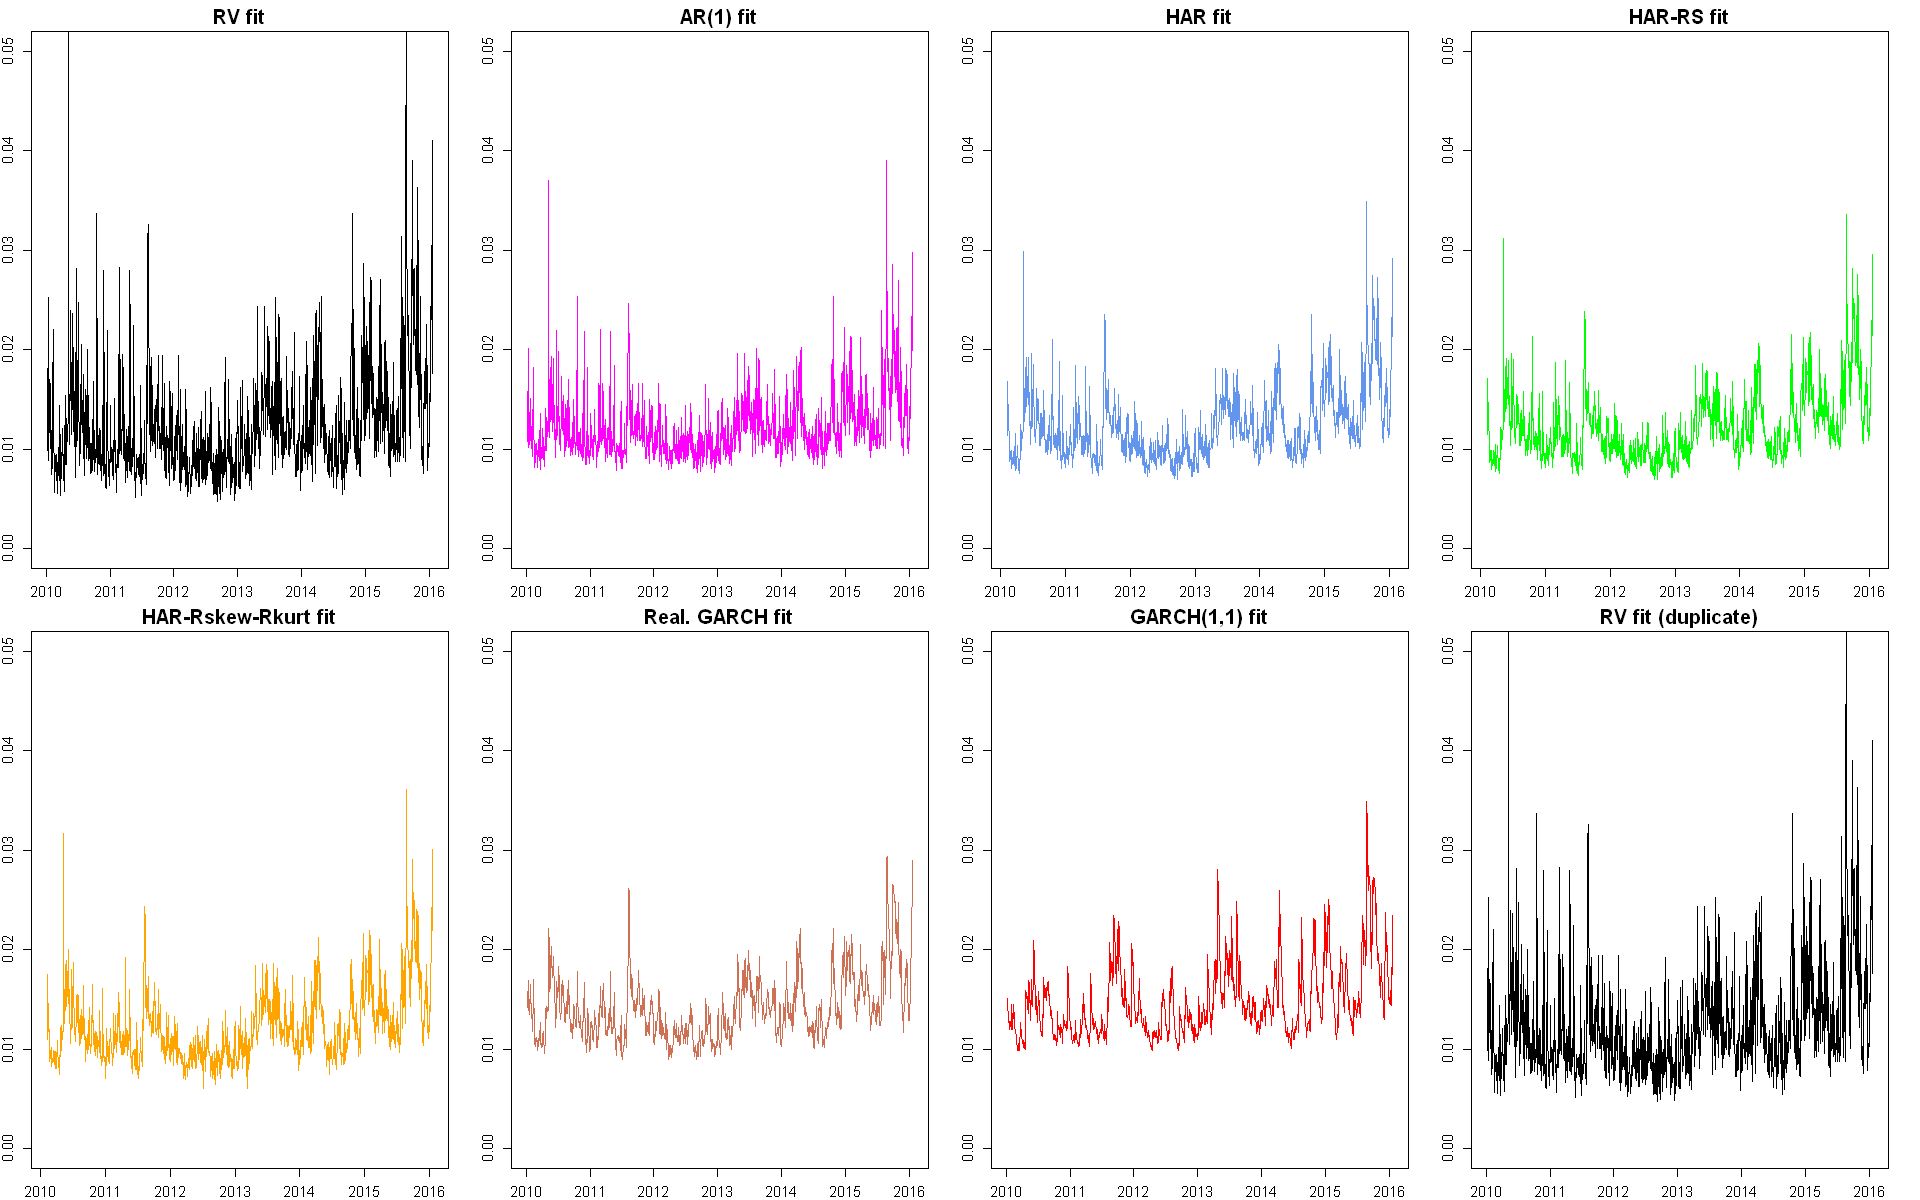

In [25]:
options(repr.plot.width = 16, repr.plot.height = 10)
par(mfrow = c(2, 4), mar = c(2, 2, 2, 2), cex.axis = 1.15, cex.main = 1.5, cex.lab = 1.2)
plot.zoo(amgn$RV, ylim = c(0, 0.05), main = "RV fit")
plot.zoo(ar1_fit, col = "magenta", ylim = c(0, 0.05), main = "AR(1) fit")
plot.zoo(har_fit, col = "cornflowerblue", ylim = c(0, 0.05), main = "HAR fit")
plot.zoo(har_rs_fit, col = "green", ylim = c(0, 0.05), main = "HAR-RS fit")
plot.zoo(har_skew_kurt_fit, col = "orange", ylim = c(0, 0.05), main = "HAR-Rskew-Rkurt fit")
plot.zoo(real_garch_fit, col = "salmon3", ylim = c(0, 0.05), main = "Real. GARCH fit")
plot.zoo(armagarch_fit, col = "red", ylim = c(0, 0.05), main = "GARCH(1,1) fit")
# Same plot for symmetry
plot.zoo(amgn$RV, ylim = c(0, 0.05), main = "RV fit (duplicate)")
par(mfrow = c(1, 1))
options(repr.plot.width = 16, repr.plot.height = 8)


Not much can be inferred from these figures. Perhaps we could say that no fitted values reach such a high level of variability as RV. Maybe the AR or HAR models could be considered somewhat competitive in that regard. To get a better idea which of the models performs well in-sample, let us calculate the *R-squared* (squared correlation of fitted values and RV) and in-sample root mean square error (RMSE).



In [26]:
rsq <- function(a, b) {
  vec <- na.omit(merge(a, b))
  r2 <- as.numeric(cor(vec[, 1], vec[, 2])^2)
  round(r2, 4)
}

rmses_in_sample <- c(
  rmse(amgn$RV, ar1_fit),
  rmse(amgn$RV[23:TT], har_fit),
  rmse(amgn$RV[23:TT], har_rs_fit),
  rmse(amgn$RV[23:TT], har_skew_kurt_fit),
  rmse(amgn$RV, real_garch_fit),
  rmse(amgn$RV, armagarch_fit)
)

rsquareds <- c(
  rsq(amgn$RV, ar1_fit),
  rsq(amgn$RV[23:TT], har_fit),
  rsq(amgn$RV[23:TT], har_rs_fit),
  rsq(amgn$RV[23:TT], har_skew_kurt_fit),
  rsq(amgn$RV, real_garch_fit),
  rsq(amgn$RV, armagarch_fit)
)

df <- as.data.frame(cbind(rmses_in_sample, rsquareds))
colnames(df) <- c("In-sample RMSE", "R-squared")
rownames(df) <- c("AR(1)", "HAR", "HAR-RS", "HAR-Rskew-Rkurt", "Real. GARCH", "GARCH(1,1)")
df

,In-sample RMSE,R-squared
,<dbl>,<dbl>
AR(1),0.004058099,0.3746
HAR,0.003879316,0.4319
HAR-RS,0.003864604,0.4362
HAR-Rskew-Rkurt,0.003824314,0.4479
Real. GARCH,0.004396410,0.4072
"GARCH(1,1)",0.005431310,0.2030


Let us note that, in the above table, we are looking for low values of RMSE and high values of R-squared. Thus, we can see that the HAR-family models perform best in both regards – around 0.0038 in terms of RMSE and more than 43% with regard to our R-squared measure. The $GARCH(1,1)$, on the other hand, appears to be objectively the worst, which is unsurprising given the outcome variable.

# 3. Forecasts

Let us continue by forecasting these models out-of-sample using the rolling and recursive schemes. Because the sample size is 1500, we split our data 1:1 into an in-sample set and an out-of-sample set, both thus having 750 observations. In some cases, the number of observations in the latter set is lower due to the construction of the model (namely HAR models). Then, we will compare these forecasts using several measures.

Under each model's code cell, we include a plot of the one-step-ahead predictions using the two schemes against the actual values of RV. We will briefly comment on the graphs in each of these instances. Forecast errors of these specifications will be plotted in one figure towards the end of this section.

### 3.1 AR(1)-RV

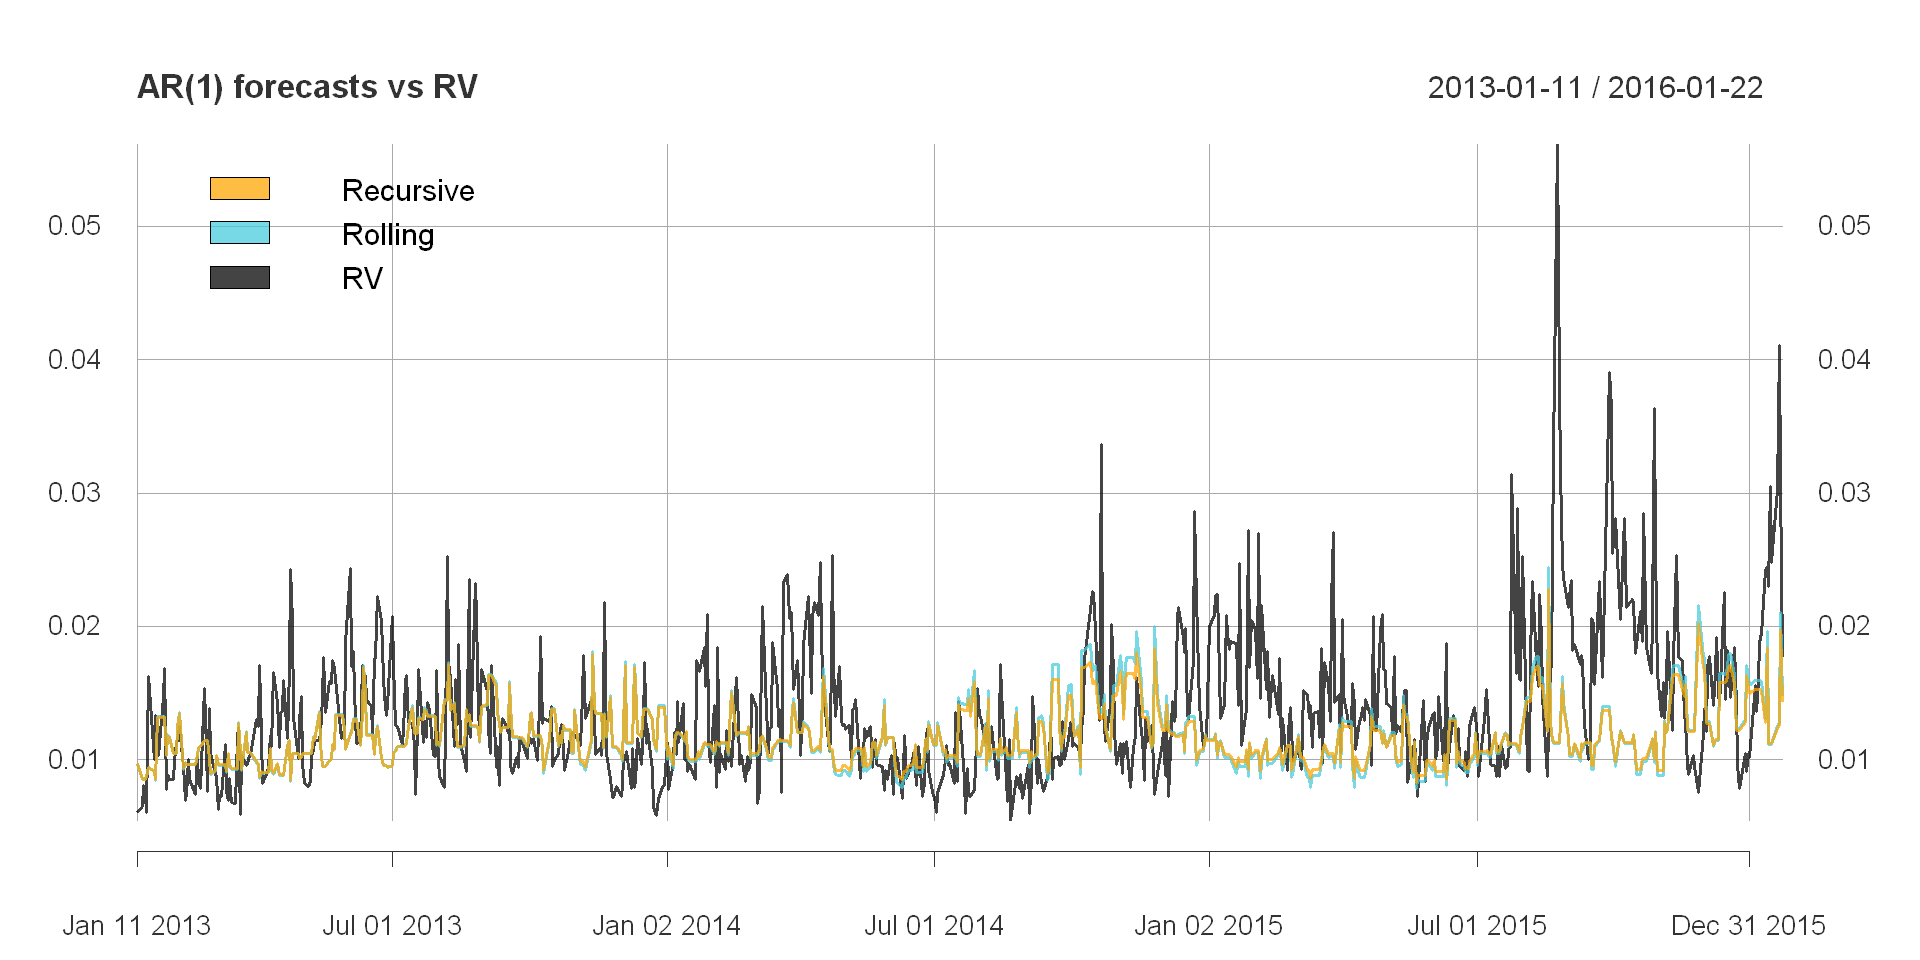

In [27]:
# Initialize dates
start_date <- index(amgn$RV)[1]
mid_date <- index(amgn$RV)[750]
end_date <- index(amgn$RV)[length(amgn$RV)]

# Out of sample set
testing_ar <- window(amgn$RV, start = mid_date + 1, end = end_date)

# Empty forecast vectors
forecasts_rec_ar <- rep(NA, length(testing_ar))
forecasts_roll_ar <- rep(NA, length(testing_ar))

# RECURSIVE
for (i in 0:(length(testing_ar) - 1)) {
  # Prepare dataset and fit in-sample
  temp_dataset <- window(amgn$RV, start = start_date, end = mid_date + i)
  mod <- Arima(temp_dataset, order = c(1, 0, 0))
  # Save forecasts
  forecasts_rec_ar[i + 1] <- predict(mod, n.ahead = 1)$pred[1]
}

# ROLLING
for (i in 0:(length(testing_ar) - 1)) {
  temp_dataset <- window(amgn$RV, start = start_date + i, end = mid_date + i)
  mod <- Arima(temp_dataset, order = c(1, 0, 0))
  forecasts_roll_ar[i + 1] <- predict(mod, n.ahead = 1)$pred[1]
}

# Merge for prettier graphs
dat_ar <- merge(
  xts(forecasts_rec_ar, order.by = index(amgn$RV[751:1500])),
  xts(forecasts_roll_ar, order.by = index(amgn$RV[751:1500])),
  amgn$RV[751:1500]
)

colnames(dat_ar) <- c("Recursive", "Rolling", "RV")

plot(
  dat_ar,
  main = "AR(1) forecasts vs RV",
  col = c("#FFA500BB", "#46CBDBBB", "#000000BB"),
  lwd = 3,
  legend.loc = "topleft",
  cex = 1
)

Despite the relatively strong in-sample performance of the AR(1) model, the results above do not seem to be as accurate regardless of the forecasting scheme.

### 3.2 HAR, HAR-RS and HAR-Rskew-Rkurt

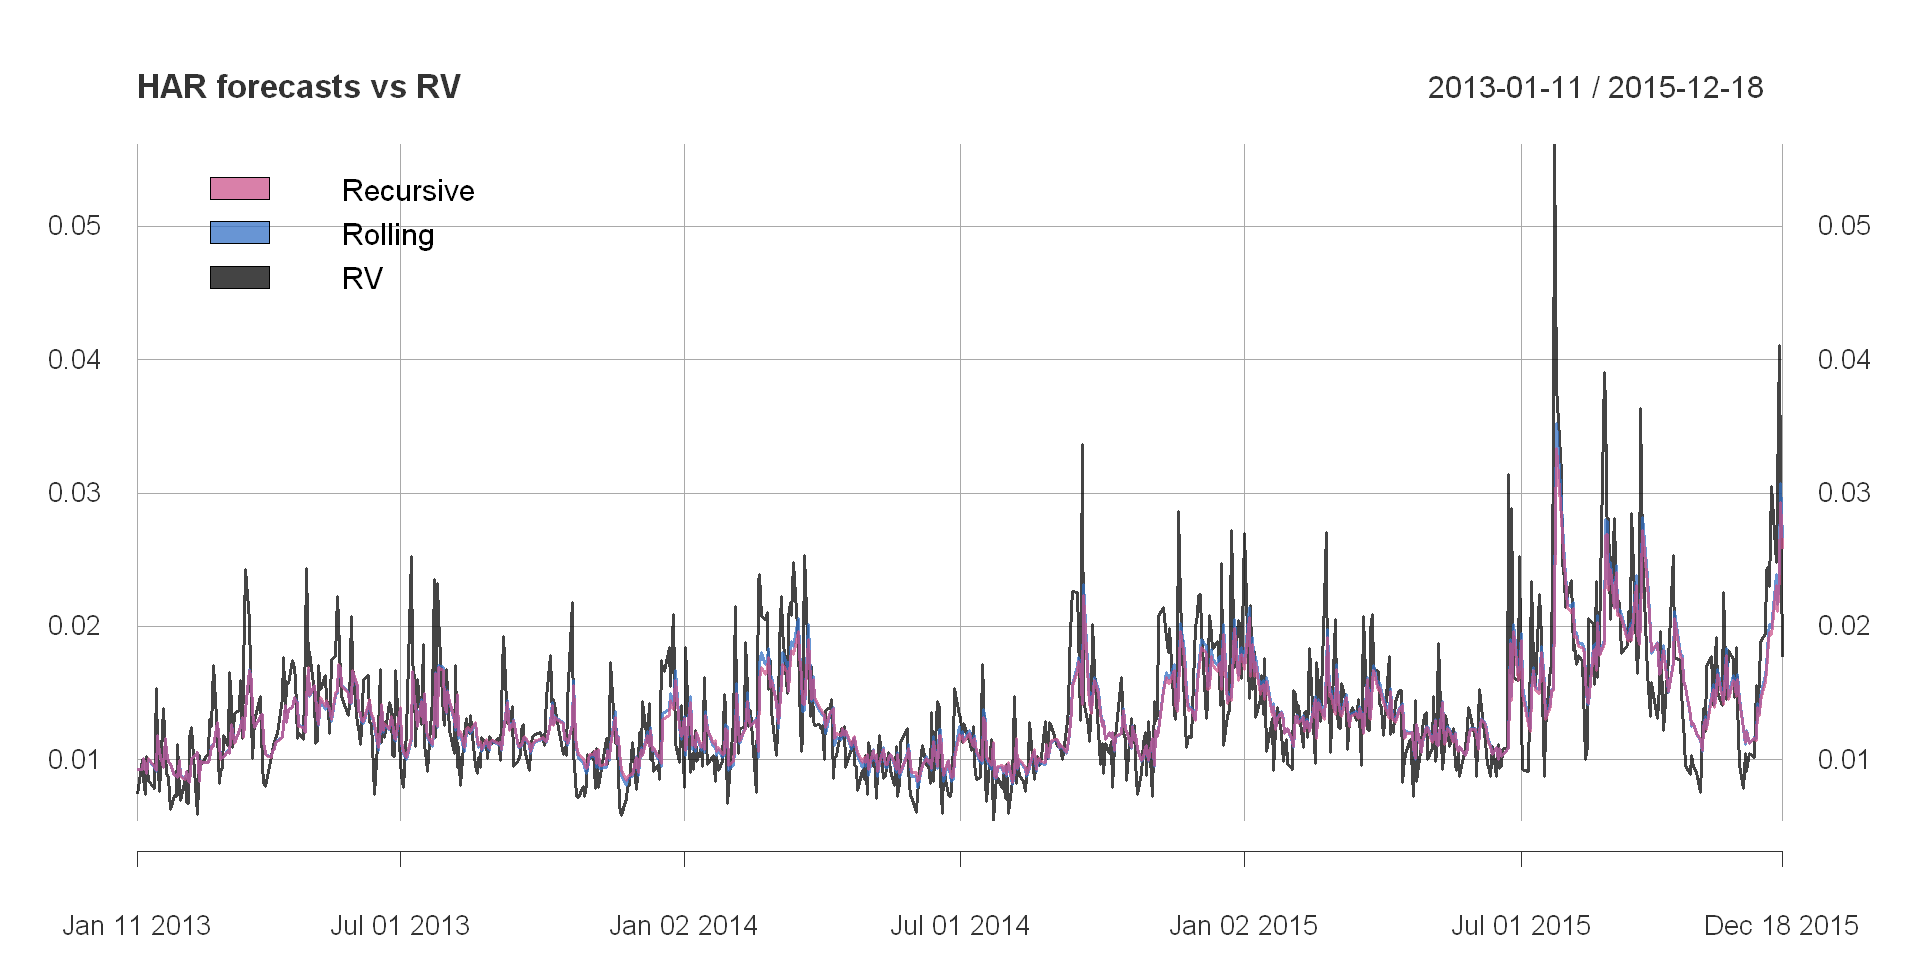

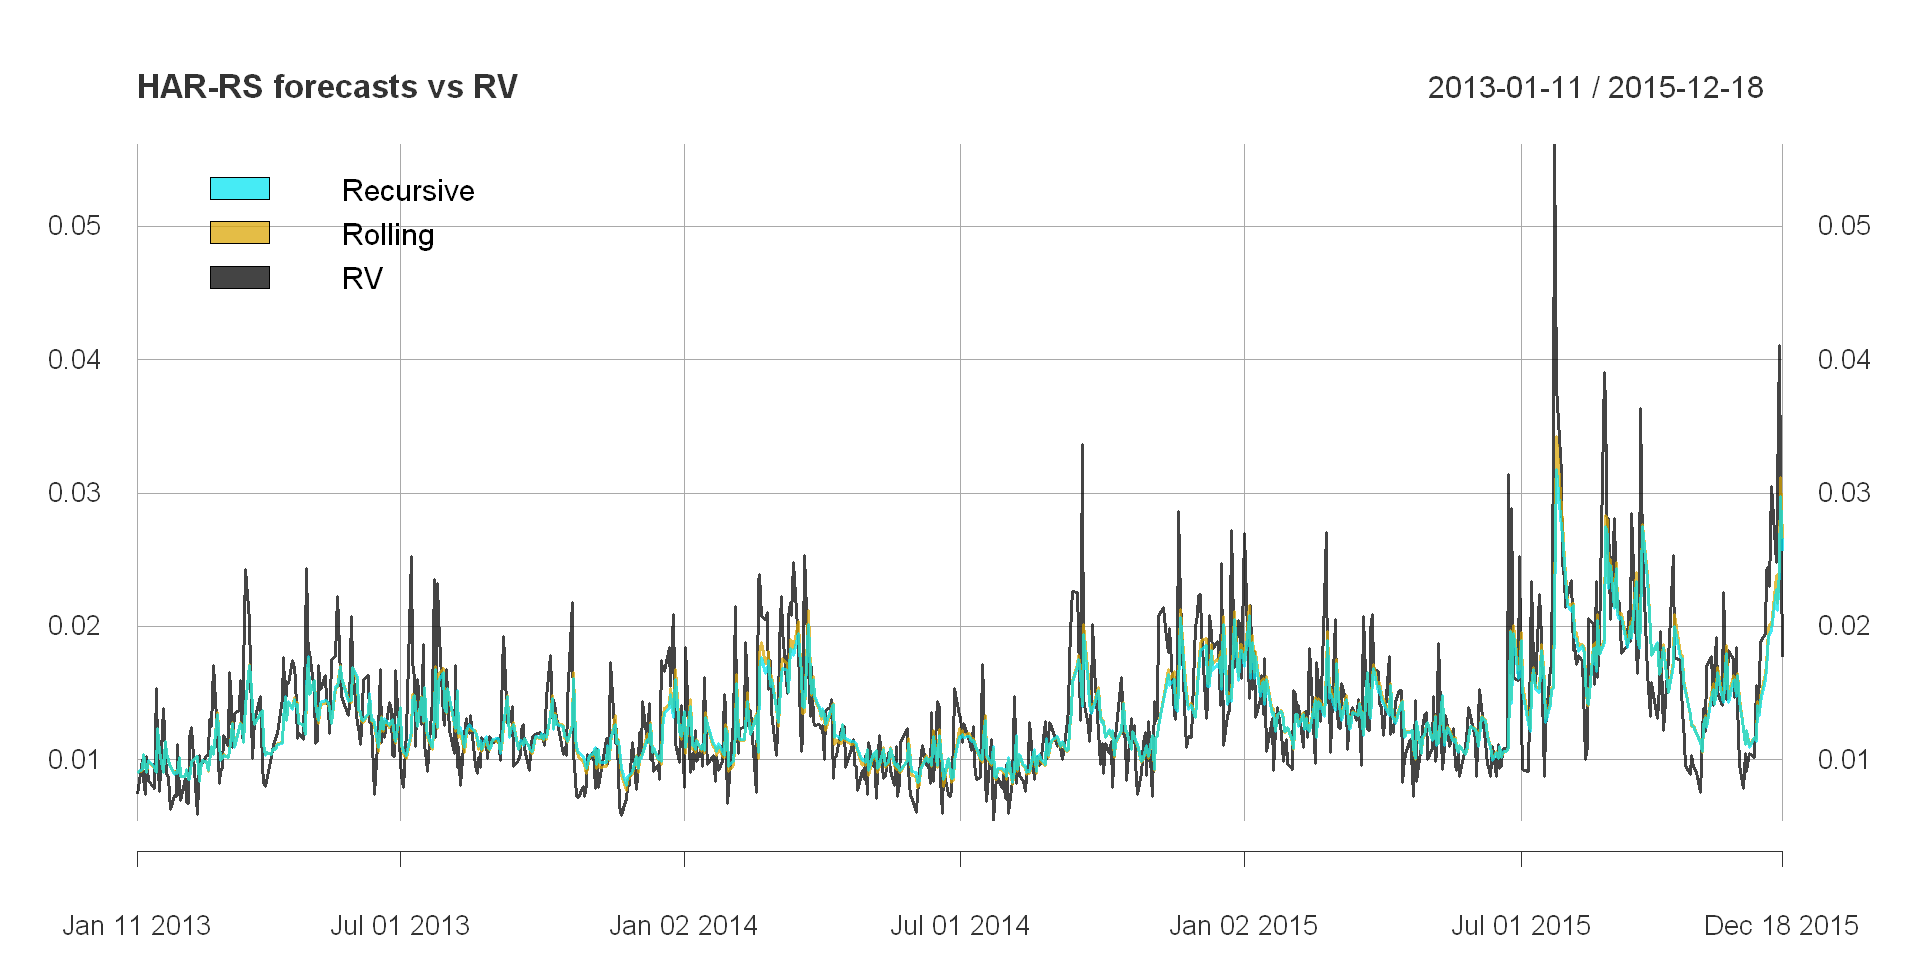

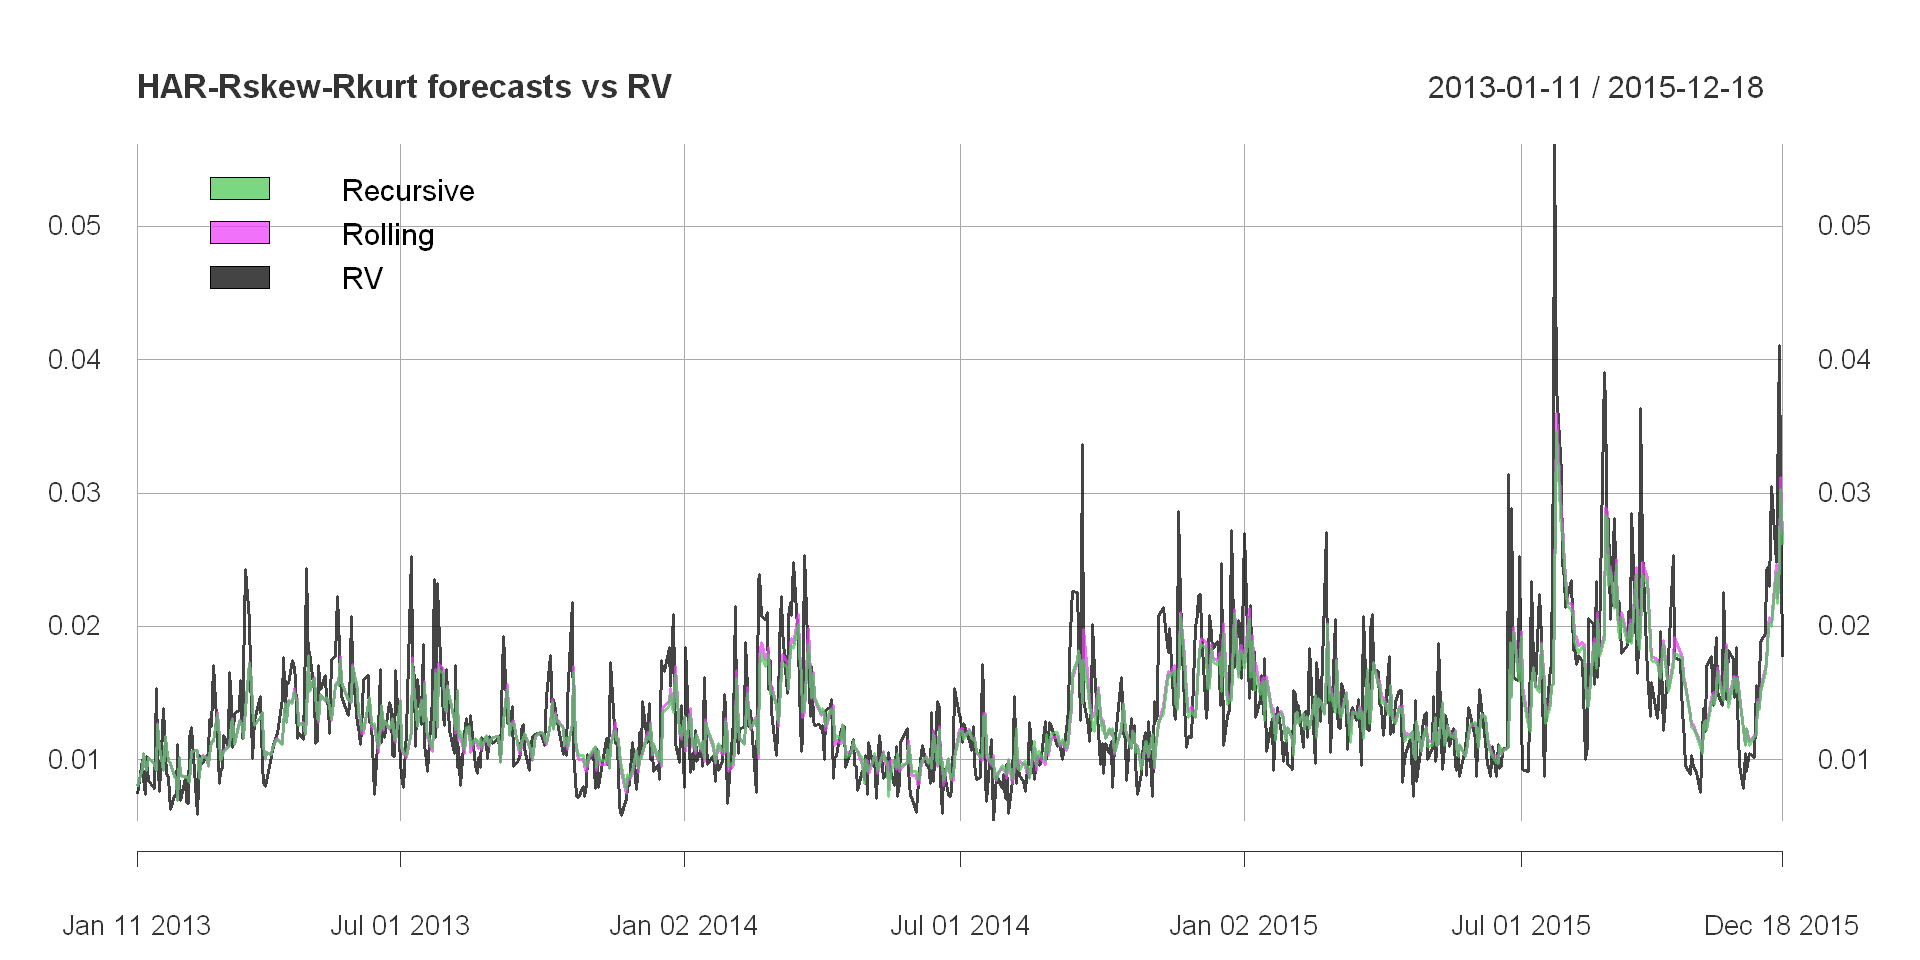

In [28]:
start_pos <- 1
mid_pos <- 750
end_pos <- nrow(har_data_ts)

testing_har <- har_data_ts[(mid_pos + 1):end_pos, ] %>% ts()

forecasts_rec_har <- rep(NA, nrow(testing_har))
forecasts_roll_har <- rep(NA, nrow(testing_har))
forecasts_rec_har_rs <- rep(NA, nrow(testing_har))
forecasts_roll_har_rs <- rep(NA, nrow(testing_har))
forecasts_rec_har_sk <- rep(NA, nrow(testing_har))
forecasts_roll_har_sk <- rep(NA, nrow(testing_har))

# RECURSIVE
for (i in 0:(nrow(testing_har) - 1)) {
  # Prepare data and estimate
  temp_dataset <- har_data_ts[start_pos:(mid_pos + i), ] %>% ts()
  newdat <- har_data[mid_pos + i + 1, -1]
  mod_har <- tslm(rv_t0 ~ rv_t1 + rv5 + rv22, data = temp_dataset)
  mod_har_rs <- tslm(rv_t0 ~ rvn + rvp + rv5 + rv22, data = temp_dataset)
  mod_har_sk <- tslm(rv_t0 ~ rv_t1 + rv5 + rv22 + rk + rs, data = temp_dataset)

  # Save forecasts
  forecasts_rec_har[i + 1] <- forecast(mod_har, newdata = newdat)$mean[1]
  forecasts_rec_har_rs[i + 1] <- forecast(mod_har_rs, newdata = newdat)$mean[1]
  forecasts_rec_har_sk[i + 1] <- forecast(mod_har_sk, newdata = newdat)$mean[1]
}

# ROLLING
for (i in 0:(nrow(testing_har) - 1)) {
  temp_dataset <- har_data_ts[(start_pos + i):(mid_pos + i), ] %>% ts()
  newdat <- har_data[mid_pos + i + 1, -1]
  mod_har <- tslm(rv_t0 ~ rv_t1, data = temp_dataset)
  mod_har_rs <- tslm(rv_t0 ~ rvn + rvp + rv5 + rv22, data = temp_dataset)
  mod_har_sk <- tslm(rv_t0 ~ rv_t1 + rv5 + rv22 + rk + rs, data = temp_dataset)

  forecasts_roll_har[i + 1] <- forecast(mod_har, newdata = newdat)$mean[1]
  forecasts_roll_har_rs[i + 1] <- forecast(mod_har_rs, newdata = newdat)$mean[1]
  forecasts_roll_har_sk[i + 1] <- forecast(mod_har_sk, newdata = newdat)$mean[1]
}

dat_har <- merge(
  xts(forecasts_rec_har, order.by = index(amgn$RV[751:(1500 - 22)])),
  xts(forecasts_roll_har, order.by = index(amgn$RV[751:(1500 - 22)])),
  xts(testing_har[, "rv_t0"], order.by = index(amgn$RV[751:(1500 - 22)]))
)
dat_har_rs <- merge(
  xts(forecasts_rec_har_rs, order.by = index(amgn$RV[751:(1500 - 22)])),
  xts(forecasts_roll_har_rs, order.by = index(amgn$RV[751:(1500 - 22)])),
  xts(testing_har[, "rv_t0"], order.by = index(amgn$RV[751:(1500 - 22)]))
)
dat_har_sk <- merge(
  xts(forecasts_rec_har_sk, order.by = index(amgn$RV[751:(1500 - 22)])),
  xts(forecasts_roll_har_sk, order.by = index(amgn$RV[751:(1500 - 22)])),
  xts(testing_har[, "rv_t0"], order.by = index(amgn$RV[751:(1500 - 22)]))
)

colnames(dat_har) <- c("Recursive", "Rolling", "RV")
colnames(dat_har_rs) <- c("Recursive", "Rolling", "RV")
colnames(dat_har_sk) <- c("Recursive", "Rolling", "RV")

plot(
  dat_har,
  main = "HAR forecasts vs RV",
  col = c("#CB528ABB", "#316FC5BB", "#000000BB"),
  lwd = 3,
  legend.loc = "topleft",
  cex = 1
)
plot(
  dat_har_rs,
  main = "HAR-RS forecasts vs RV",
  col = c("#03E4F2BB", "#DAA503BB", "#000000BB"),
  lwd = 3,
  legend.loc = "topleft",
  cex = 1
)
plot(
  dat_har_sk,
  main = "HAR-Rskew-Rkurt forecasts vs RV",
  col = c("#4BC854BB", "#EC3DFABB", "#000000BB"),
  lwd = 3,
  legend.loc = "topleft",
  cex = 1
)

The HAR-family models, on the other hand, seem to perform very well in the out-of-sample forecasting exercise, purely just by observing the figures.

### 3.3 Realized GARCH and ARMA-GARCH


```r
f_rec_rg <- ugarchroll(
  realgarchspec,
  amgn$ret,
  n.ahead = 1,
  forecast.length = 750,
  refit.every = 1,
  refit.window = "recursive",
  realizedVol = sqrt(amgn$RV),
  calculate.VaR = F,
  window.size = 750,
  solver = "gosolnp"
)
f_rec_rg <- resume(f_rec_rg, solver = "gosolnp")

f_roll_rg <- ugarchroll(
  realgarchspec,
  amgn$ret,
  n.ahead = 1,
  forecast.length = 750,
  refit.every = 1,
  refit.window = "moving",
  realizedVol = sqrt(amgn$RV),
  calculate.VaR = F,
  window.size = 750,
  solver = "gosolnp"
)
f_roll_rg <- resume(f_roll_rg, solver = "gosolnp")

f_rec_ag <- ugarchroll(
  armagarchspec,
  amgn$ret,
  n.ahead = 1,
  forecast.length = 750,
  refit.every = 1,
  refit.window = "recursive",
  calculate.VaR = F,
  window.size = 750
)

f_roll_ag <- ugarchroll(
  armagarchspec,
  amgn$ret,
  n.ahead = 1,
  forecast.length = 750,
  refit.every = 1,
  refit.window = "moving",
  calculate.VaR = F,
  window.size = 750
)

# Remove outliers
out1 <- boxplot.stats(f_rec_rg@forecast$density$Sigma)$out
f_out1 <- f_rec_rg@forecast$density$Sigma
f_out1[f_out1 %in% out1] <- NA
out2 <- boxplot.stats(f_roll_rg@forecast$density$Sigma)$out
f_out2 <- f_roll_rg@forecast$density$Sigma
f_out2[f_out2 %in% out2] <- NA

fcsts_garch <- cbind(
  f_out1,
  f_out2,
  f_rec_ag@forecast$density$Sigma,
  f_roll_ag@forecast$density$Sigma
)
colnames(fcsts_garch) <- c(
  "forecasts_rec_rg",
  "forecasts_roll_rg",
  "forecasts_rec_ag",
  "forecasts_roll_ag"
)
```

There were a few issues with the convergence of the optimization algorithm, which sometimes resulted in nonsensical results (27 cases). These results were treated as outliers and were removed from the final vector of forecasts. One way to determine whether a value is an outlier is through a box-plot, which is exactly what we exploited above.

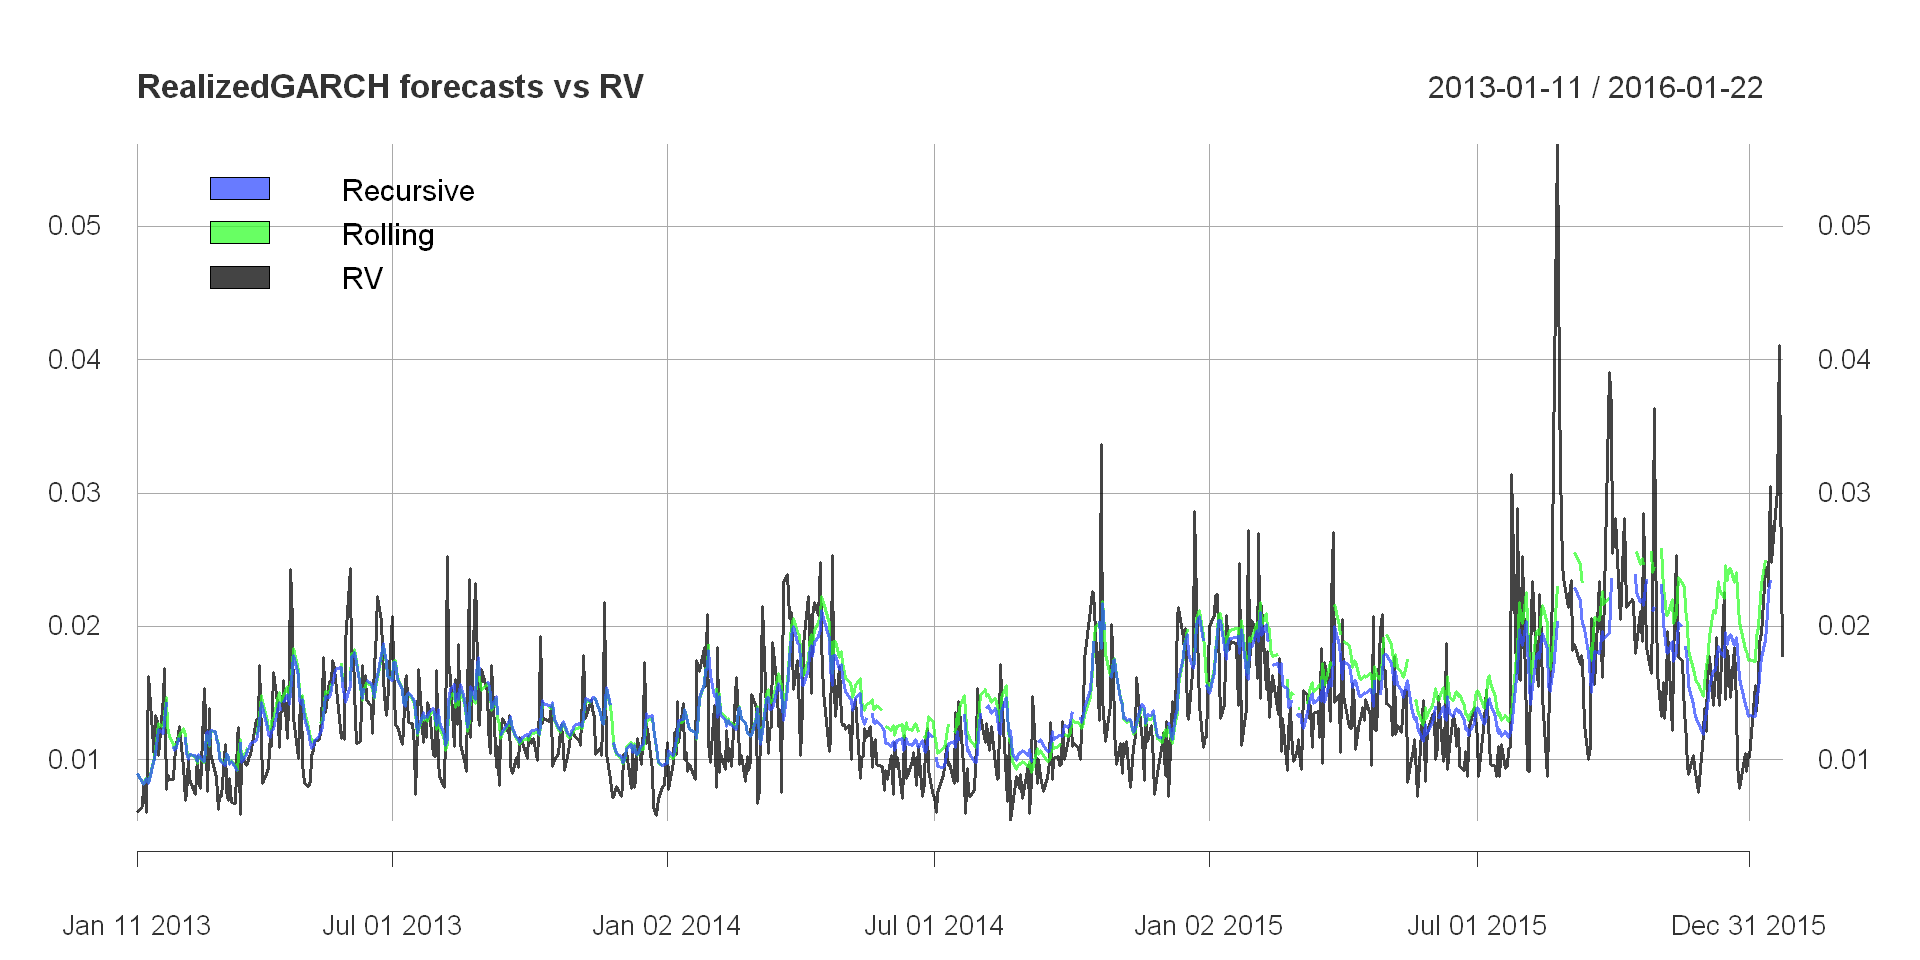

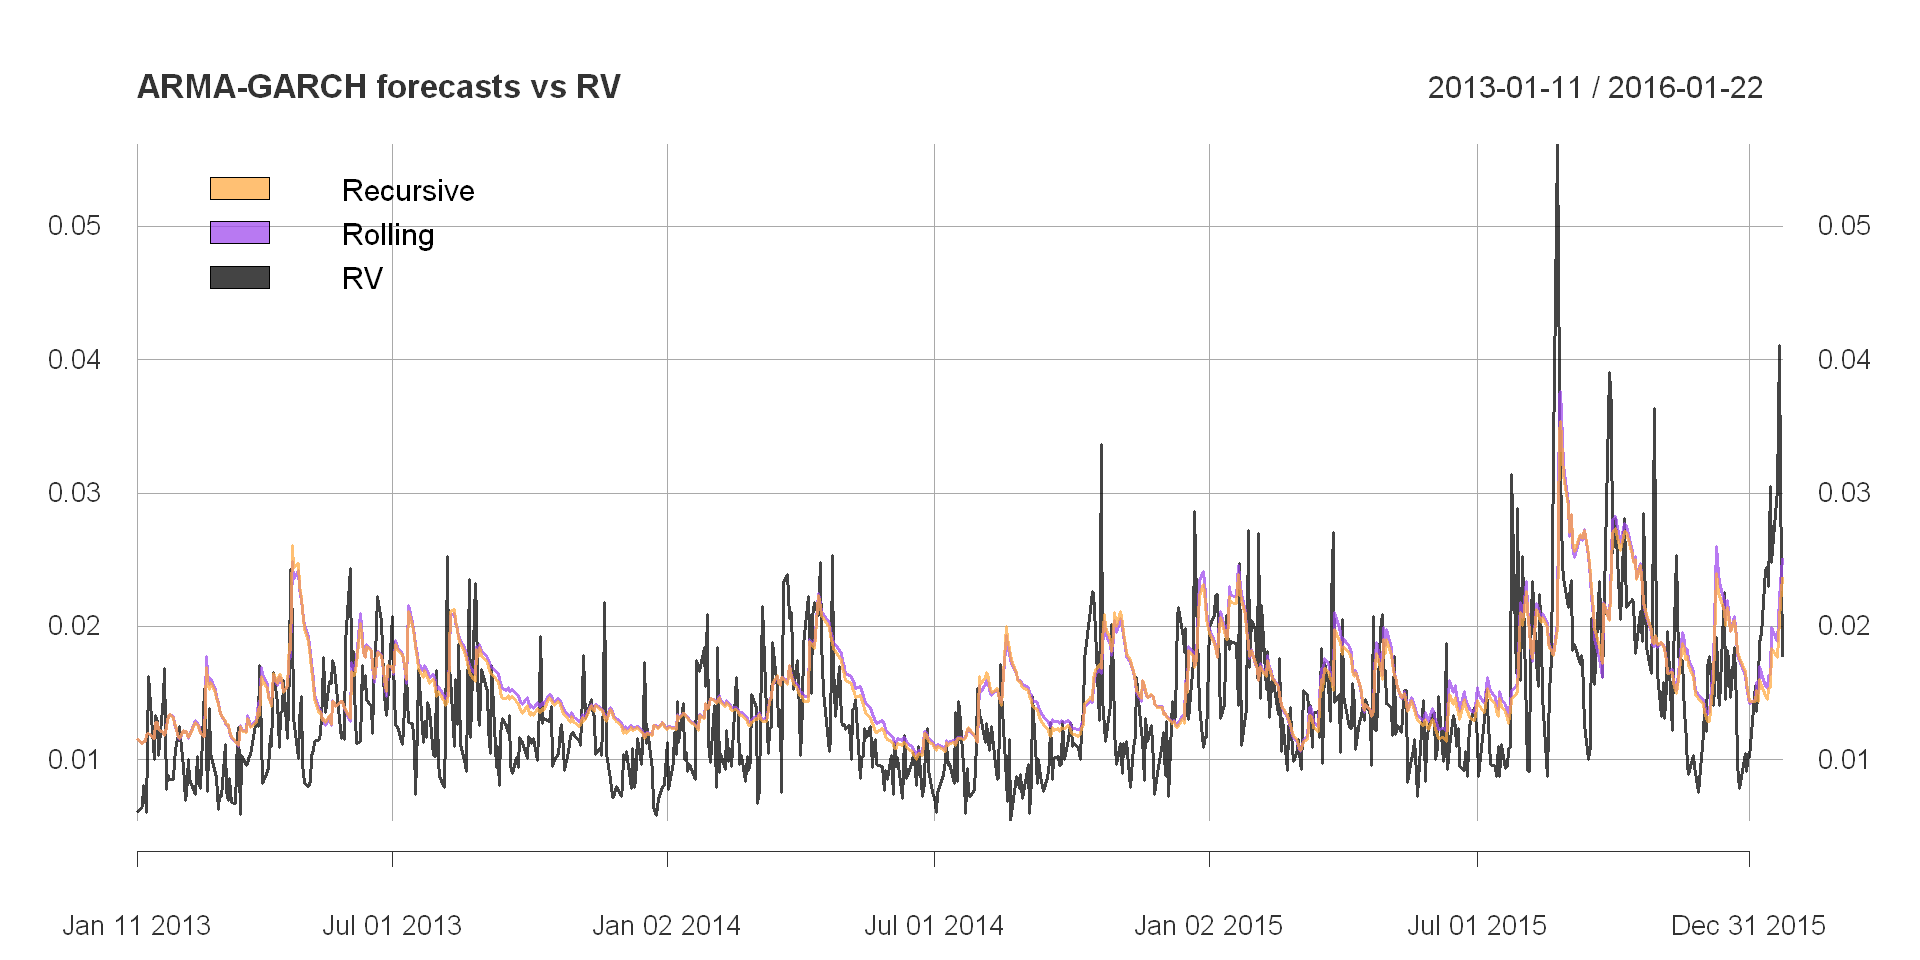

In [29]:
# LOAD THE FORECASTS TO SAVE TIME
fcsts_garch <- readRDS("fcsts_garch.RData") %>%
  as.xts(index(amgn$RV[751:1500]))

dat_rg <- merge(
  fcsts_garch[, "forecasts_rec_rg"],
  fcsts_garch[, "forecasts_roll_rg"],
  amgn$RV[751:1500]
)

dat_ag <- merge(
  fcsts_garch[, "forecasts_rec_ag"],
  fcsts_garch[, "forecasts_roll_ag"],
  amgn$RV[751:1500]
)

colnames(dat_rg) <- c("Recursive", "Rolling", "RV")
colnames(dat_ag) <- c("Recursive", "Rolling", "RV")

plot(
  dat_rg,
  main = "RealizedGARCH forecasts vs RV",
  col = c("#314BFFBB", "#31FF2ABB", "#000000BB"),
  lwd = 3,
  legend.loc = "topleft",
  cex = 1
)

plot(
  dat_ag,
  main = "ARMA-GARCH forecasts vs RV",
  col = c("#FFA940BB", "#9E48EDBB", "#000000BB"),
  lwd = 3,
  legend.loc = "topleft",
  cex = 1
)


While the realized GARCH specification appears to perform relatively competitively, the $GARCH(1,1)$ specification cannot *keep-up* and offers quite a *smooth* forecast no matter the scheme.

### 3.4 Forecast errors

In [30]:
ar_rec_err <- testing_ar - forecasts_rec_ar
ar_roll_err <- testing_ar - forecasts_roll_ar

har_rec_err <- testing_har[, "rv_t0"] - forecasts_rec_har
har_roll_err <- testing_har[, "rv_t0"] - forecasts_roll_har
har_rs_rec_err <- testing_har[, "rv_t0"] - forecasts_rec_har_rs
har_rs_roll_err <- testing_har[, "rv_t0"] - forecasts_roll_har_rs
har_sk_rec_err <- testing_har[, "rv_t0"] - forecasts_rec_har_sk
har_sk_roll_err <- testing_har[, "rv_t0"] - forecasts_roll_har_sk

garch_rg_rec_err <- testing_ar - fcsts_garch[, "forecasts_rec_rg"]
garch_rg_roll_err <- testing_ar - fcsts_garch[, "forecasts_roll_rg"]
garch_ag_rec_err <- testing_ar - fcsts_garch[, "forecasts_rec_ag"]
garch_ag_roll_err <- testing_ar - fcsts_garch[, "forecasts_roll_ag"]

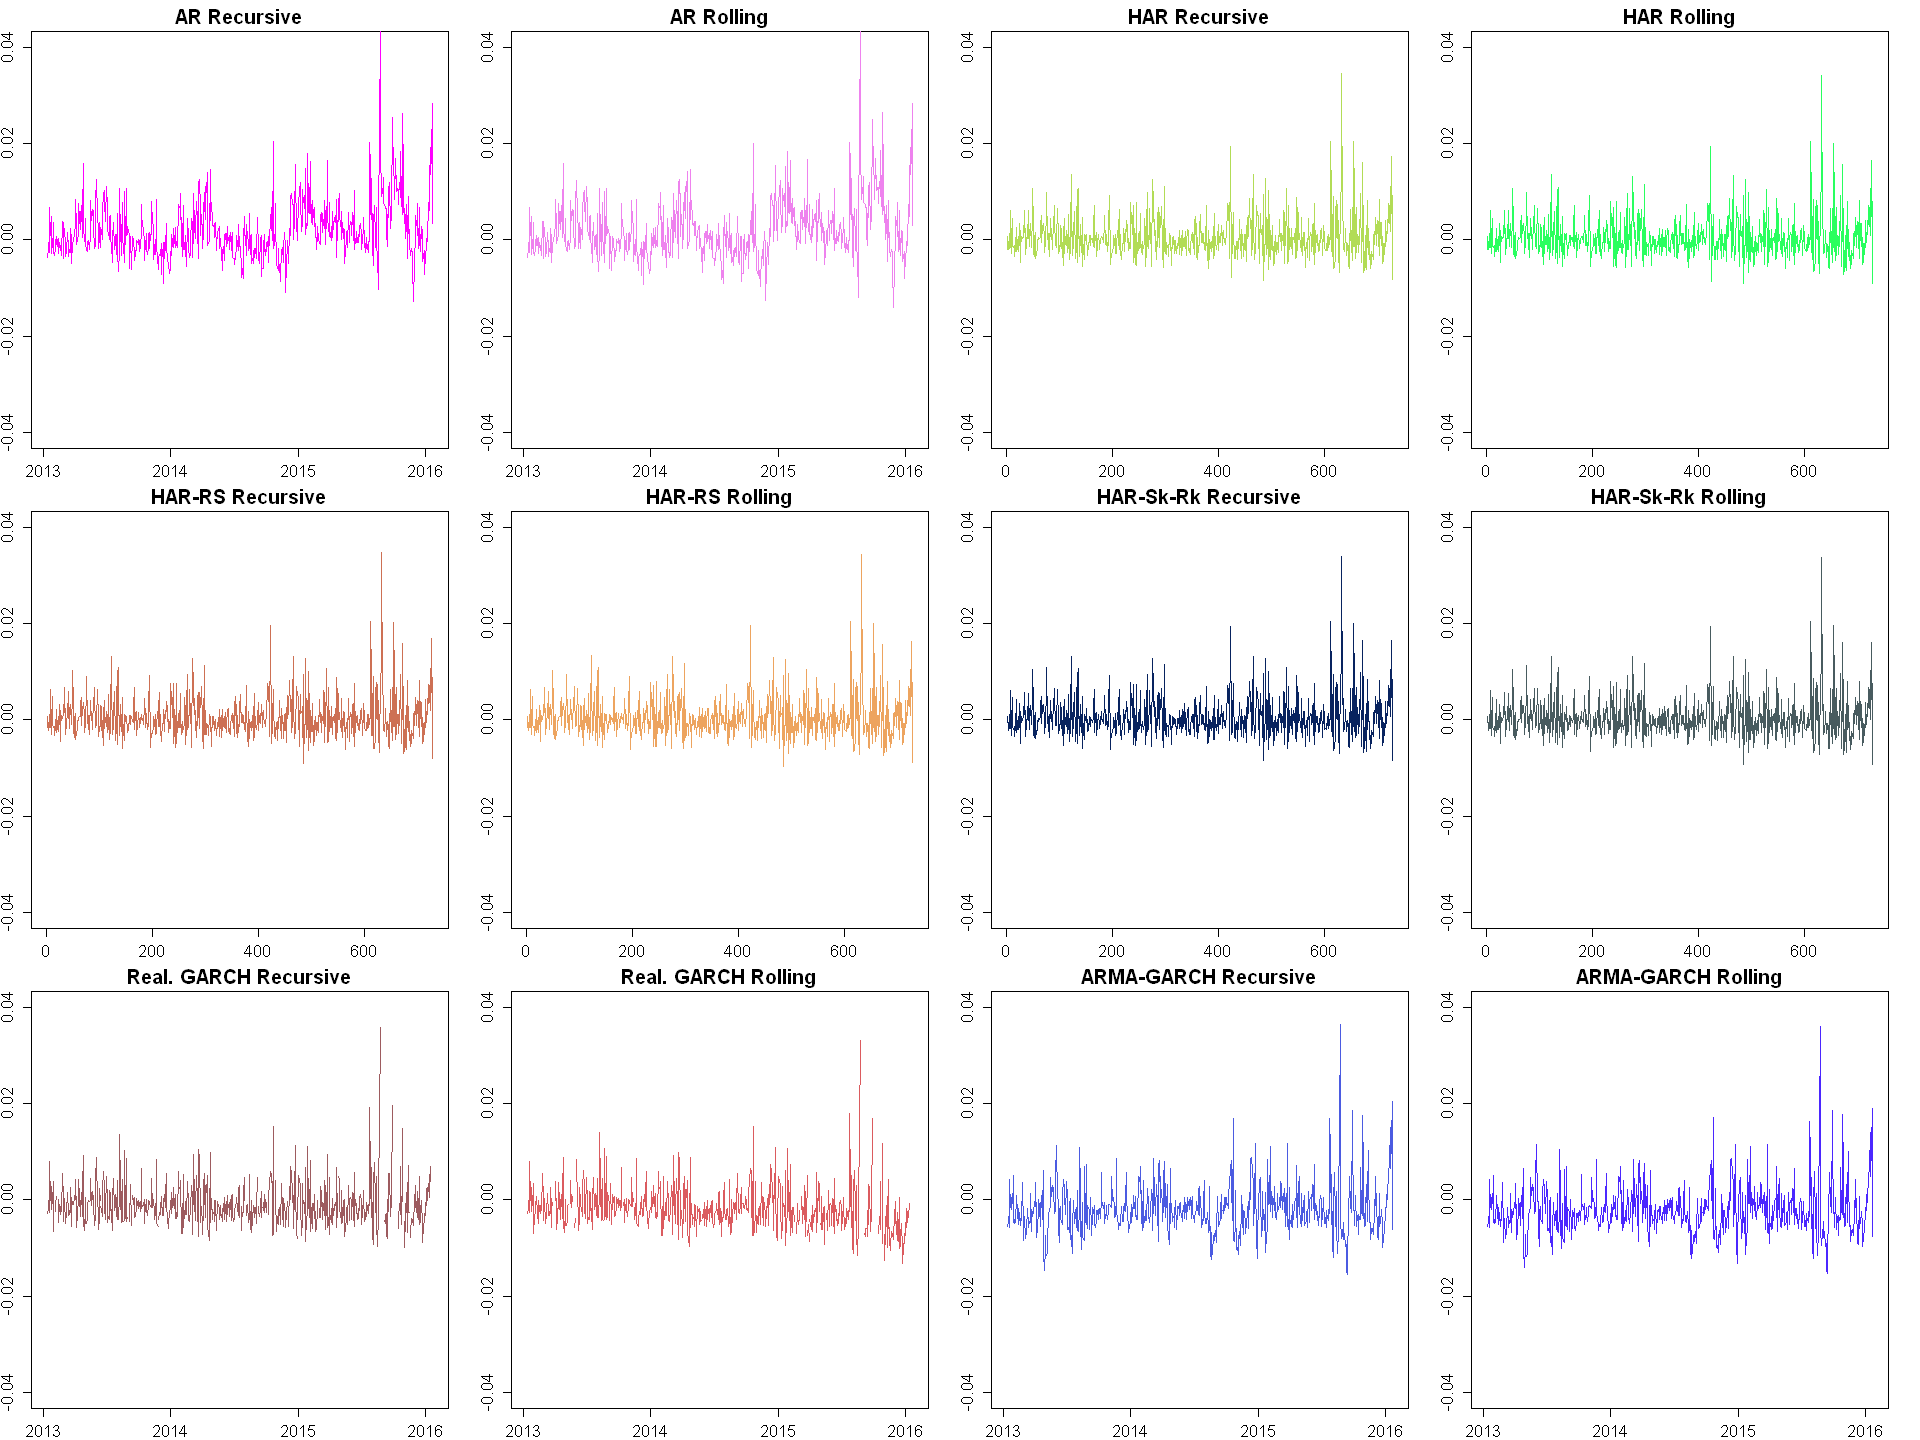

In [31]:
options(repr.plot.width = 16, repr.plot.height = 12)
par(mfrow = c(3, 4), mar = c(2, 2, 2, 2), cex.axis = 1.3, cex.main = 1.5, cex.lab = 1.5)
plot.zoo(ar_rec_err, col = "magenta", ylim = c(-0.04, 0.04), main = "AR Recursive")
plot.zoo(ar_roll_err, col = "violet", ylim = c(-0.04, 0.04), main = "AR Rolling")
plot.zoo(har_rec_err, col = "#B2DC56", ylim = c(-0.04, 0.04), main = "HAR Recursive")
plot.zoo(har_roll_err, col = "#29FF5F", ylim = c(-0.04, 0.04), main = "HAR Rolling")
plot.zoo(har_rs_rec_err, col = "salmon3", ylim = c(-0.04, 0.04), main = "HAR-RS Recursive")
plot.zoo(har_rs_roll_err, col = "#EDA45F", ylim = c(-0.04, 0.04), main = "HAR-RS Rolling")
plot.zoo(har_sk_rec_err, col = "#08235F", ylim = c(-0.04, 0.04), main = "HAR-Sk-Rk Recursive")
plot.zoo(har_sk_roll_err, col = "#485B5F", ylim = c(-0.04, 0.04), main = "HAR-Sk-Rk Rolling")
plot.zoo(garch_rg_rec_err, col = "#9D5B5F", ylim = c(-0.04, 0.04), main = "Real. GARCH Recursive")
plot.zoo(garch_rg_roll_err, col = "#DB5B5F", ylim = c(-0.04, 0.04), main = "Real. GARCH Rolling")
plot.zoo(garch_ag_rec_err, col = "#4B5BE1", ylim = c(-0.04, 0.04), main = "ARMA-GARCH Recursive")
plot.zoo(garch_ag_roll_err, col = "#4B27FF", ylim = c(-0.04, 0.04), main = "ARMA-GARCH Rolling")
par(mfrow = c(1, 1))
options(repr.plot.width = 16, repr.plot.height = 8)

Above, we see all the one-step-ahead out-of-sample forecast errors in one picture. The y-axis is fixed, allowing for direct comparison. A forecast error is simply defined as the $actual-predicted$ value of the series, meaning that a forecast error of zero means that the model predicted the value perfectly. While we cannot expect any model to forecast perfectly, we can look for models which *make the least mistakes*. Therefore, what we are looking for in the graphs above is the least amount of variability. We believe that the HAR family models could be considered as the most accurate using this heuristic.

However, to objectively determine, which model and scheme produced the most accurate one-step-ahead predictions, we should instead study error measures. These essentially give us a single point of reference, facilitating comparison across specifications. The error measures we employ are the mean square error (MSE) and mean absolute error (MAE). Letting $\hat e_{t+1|t}=y_{t+1}-\hat y_{t+1|t}$ be the series of one-step-ahead forecast errors, the MSE and MAE are defined as:

$$
\begin{align*}
\text{MSE} &= h^{-1} \sum_{j=1}^h \hat e_{j,t+1|t}^2 \\
\text{MAE} &= h^{-1} \sum_{j=1}^h |\hat e_{j,t+1|t}| \\
\end{align*}
$$

where $h$ is the length of the out-of-sample set (horizon).

In [32]:
mses <- matrix(
  c(
    mean(ar_rec_err^2, na.rm = T),
    mean(ar_roll_err^2, na.rm = T),
    mean(har_rec_err^2, na.rm = T),
    mean(har_roll_err^2, na.rm = T),
    mean(har_rs_rec_err^2, na.rm = T),
    mean(har_rs_roll_err^2, na.rm = T),
    mean(har_sk_rec_err^2, na.rm = T),
    mean(har_sk_roll_err^2, na.rm = T),
    mean(garch_rg_rec_err^2, na.rm = T),
    mean(garch_rg_roll_err^2, na.rm = T),
    mean(garch_ag_rec_err^2, na.rm = T),
    mean(garch_ag_roll_err^2, na.rm = T)
  ),
  ncol = 2,
  byrow = T
)
colnames(mses) <- c("MSE Recursive", "MSE Rolling")
rownames(mses) <- c("AR", "HAR", "HAR-RS", "HAR-RSkew-RKurt", "rGARCH", "ARMA-GARCH")

mses

maes <- matrix(
  c(
    mean(abs(ar_rec_err), na.rm = T),
    mean(abs(ar_roll_err), na.rm = T),
    mean(abs(har_rec_err), na.rm = T),
    mean(abs(har_roll_err), na.rm = T),
    mean(abs(har_rs_rec_err), na.rm = T),
    mean(abs(har_rs_roll_err), na.rm = T),
    mean(abs(har_sk_rec_err), na.rm = T),
    mean(abs(har_sk_roll_err), na.rm = T),
    mean(abs(garch_rg_rec_err), na.rm = T),
    mean(abs(garch_rg_roll_err), na.rm = T),
    mean(abs(garch_ag_rec_err), na.rm = T),
    mean(abs(garch_ag_roll_err), na.rm = T)
  ),
  ncol = 2,
  byrow = T
)
colnames(maes) <- c("MAE Recursive", "MAE Rolling")
rownames(maes) <- c("AR", "HAR", "HAR-RS", "HAR-RSkew-RKurt", "rGARCH", "ARMA-GARCH")

maes


,MSE Recursive,MSE Rolling
AR,3.589391e-05,3.688607e-05
HAR,1.692589e-05,1.679652e-05
HAR-RS,1.691492e-05,1.678852e-05
HAR-RSkew-RKurt,1.652877e-05,1.653624e-05
rGARCH,1.818537e-05,2.131618e-05
ARMA-GARCH,2.773243e-05,2.854833e-05


,MAE Recursive,MAE Rolling
AR,0.004104421,0.004192835
HAR,0.002829724,0.002830468
HAR-RS,0.002850371,0.002846620
HAR-RSkew-RKurt,0.002787721,0.002801904
rGARCH,0.003173262,0.003557609
ARMA-GARCH,0.004085311,0.004203129


The lowest MSE among all the specifications was reached by the HAR-RSkew-RKurt model using the recursive forecasting scheme. The other two HAR-family models closely follow. Realized GARCH also seemed to produce relatively accurate forecasts, but the HAR models were more precise.

Using MAE as the loss function, we find almost the same results: the HAR-RSkew-RKurt model using the recursive forecasting scheme produced the most accurate forecasts according to this error measure.

Overall, the worst models appeared to be the simple autoregression and the GARCH(1,1), which is somewhat surprising given the in-sample performance of the AR(1) model.

#### Diebold-Mariano test

Next, let us perform the Diebold-Mariano (DM) test with quadratic loss on all pairs of the forecasts for completeness. Given the results of the MSE and MAE measures, we can probably guess that the HAR forecasts will be significantly more accurate than the AR forecasts. However, what we are mainly interested in is the comparison among the HAR models.

In [33]:
rows <- c(
    "AR Rec.", "AR Roll.",
    "HAR Rec.", "HAR Roll.",
    "HAR-RS Rec.", "HAR-RS Roll.",
    "HAR-Rs-Rk Rec.", "HAR-Rs-Rk Roll.",
    "rGARCH Rec.", "rGARCH Roll.",
    "ARMA-GARCH Rec.", "ARMA-GARCH Roll."
)

df_dm <- data.frame(matrix(rep(NA, 12 * 12), nrow = 12))
rownames(df_dm) <- rows
colnames(df_dm) <- rows

error_cols <- list(
    as.numeric(ar_rec_err),
    as.numeric(ar_roll_err),
    as.numeric(har_rec_err),
    as.numeric(har_roll_err),
    as.numeric(har_rs_rec_err),
    as.numeric(har_rs_roll_err),
    as.numeric(har_sk_rec_err),
    as.numeric(har_sk_roll_err),
    as.numeric(garch_rg_rec_err),
    as.numeric(garch_rg_roll_err),
    as.numeric(garch_ag_rec_err),
    as.numeric(garch_ag_roll_err)
)

# These loops create the DM table
for (i in 1:length(error_cols)) {
    for (j in 1:length(error_cols)) {
        if (length(error_cols[[i]]) != length(error_cols[[j]])) {
            # In case of differing lengths, pick the smaller number and subset
            min_length <- min(length(error_cols[[i]]), length(error_cols[[j]]))
            temp_df <- cbind(error_cols[[i]][1:min_length], error_cols[[j]][1:min_length]) %>%
                na.omit()
        } else {
            temp_df <- cbind(error_cols[[i]], error_cols[[j]]) %>%
                na.omit()
        }
        # NA and skip when comparing with itself
        if (i == j) {
            df_dm[i, j] <- NA
            next
        }
        dm <- dm.test(temp_df[, 1], temp_df[, 2], alternative = "greater", power = 2)
        df_dm[i, j] <- round(as.numeric(dm$p.value), 4)
    }
}

writeLines("P-values of a two-sided DM test")
df_dm

P-values of a two-sided DM test


,AR Rec.,AR Roll.,HAR Rec.,HAR Roll.,HAR-RS Rec.,HAR-RS Roll.,HAR-Rs-Rk Rec.,HAR-Rs-Rk Roll.,rGARCH Rec.,rGARCH Roll.,ARMA-GARCH Rec.,ARMA-GARCH Roll.
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AR Rec.,NA,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0007,0.0026
AR Roll.,0.0000,NA,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0008
HAR Rec.,1.0000,1.0000,NA,0.1079,0.4600,0.1690,0.0103,0.0195,0.6298,0.9079,0.9996,0.9999
HAR Roll.,1.0000,1.0000,0.8921,NA,0.7865,0.4679,0.0535,0.0278,0.6449,0.9179,0.9997,0.9999
HAR-RS Rec.,1.0000,1.0000,0.5400,0.2135,NA,0.1145,0.0080,0.0197,0.6294,0.9093,0.9995,0.9999
HAR-RS Roll.,1.0000,1.0000,0.8310,0.5321,0.8855,NA,0.0392,0.0188,0.6453,0.9197,0.9996,0.9999
HAR-Rs-Rk Rec.,1.0000,1.0000,0.9897,0.9465,0.9920,0.9608,NA,0.5335,0.6824,0.9362,0.9998,1.0000
HAR-Rs-Rk Roll.,1.0000,1.0000,0.9805,0.9722,0.9803,0.9812,0.4665,NA,0.6787,0.9358,0.9998,1.0000
rGARCH Rec.,1.0000,1.0000,0.3702,0.3551,0.3706,0.3547,0.3176,0.3213,NA,1.0000,1.0000,1.0000


The table above shows the p-value of the Diebold-Mariano test. Rejecting the null hypothesis of equal loss essentially means that the forecasting accuracy of the models is different. However, this does not provide enough information for us to decide which one is considered more accurate. For this reason, we employed a one-sided hypothesis test. Thus, the **lower triangular** table above is interpreted as such (the **upper triangular table** is interpreted in the exact opposite way):

> H0: The $Row_i$ model produced more accurate forecasts than the $Column_j$ model.

For instance, if we look at row 2, column 3, we see that we p-value is essentially zero, meaning that the AR rolling forecast is not more accurate than the HAR recursive forecast. Conversely, row 3, column 2 tells the opposite story (we fail to reject that HAR forecasts were more accurate).

Expectedly, some of the HAR-family models' predictions are not significantly different from each other with some notable results. For instance, the HAR-RSkew-RKurt recursive seemed to be more accurate than the HAR-RS recursive forecasts. Surprisingly, however, the realized GARCH forecasts did not seem to be statistically different from the HAR forecasts in terms of the loss.

#### Mincer-Zarnowitz regression

We conclude this chapter by running the Mincer-Zarnowitz (MZ) regression, in which we regress the actual values of the outcome variable on the predictions and jointly test whether the intercept term and slope parameter estimates are statistically different from zero and one, respectively. This can be done using, for example, the Wald test.

In [34]:
# Minzer-Zarnowitz
lm_objects <- list(
    mz_ar_rec <- lm(testing_ar ~ forecasts_rec_ar),
    mz_ar_roll <- lm(testing_ar ~ forecasts_roll_ar),
    mz_har_rec <- lm(testing_har[, "rv_t0"] ~ forecasts_rec_har),
    mz_har_roll <- lm(testing_har[, "rv_t0"] ~ forecasts_roll_har),
    mz_harrs_rec <- lm(testing_har[, "rv_t0"] ~ forecasts_rec_har_rs),
    mz_harrs_roll <- lm(testing_har[, "rv_t0"] ~ forecasts_roll_har_rs),
    mz_harsk_rec <- lm(testing_har[, "rv_t0"] ~ forecasts_rec_har_sk),
    mz_harsk_roll <- lm(testing_har[, "rv_t0"] ~ forecasts_roll_har_sk),
    mz_rg_rec <- lm(testing_ar ~ fcsts_garch[, "forecasts_rec_rg"]),
    mz_rg_roll <- lm(testing_ar ~ fcsts_garch[, "forecasts_roll_rg"]),
    mz_ag_rec <- lm(testing_ar ~ fcsts_garch[, "forecasts_rec_ag"]),
    mz_ag_roll <- lm(testing_ar ~ fcsts_garch[, "forecasts_roll_ag"])
)

perform_wald_test <- function(lm) {
    wald <- wald.test(b = coef(lm), Sigma = vcov(lm), H0 = c(0, 1), Terms = 1:2)
    coefs <- coef(lm)
    return(c(coefs, wald$result$chi2[1], round(wald$result$chi2[3], 2)))
}

# Empty df for rec and roll results
df <- as.data.frame(matrix(rep(NA, 5 * 12), ncol = 5))
cols <- c("Intercept", "Slope", "Statistic", "P-value", "R-squared")

# Reuse rows from DM table
rownames(df) <- rows
colnames(df) <- cols

for (i in 1:length(lm_objects)) {
    df[i, ] <- c(perform_wald_test(lm_objects[[i]]), summary(lm_objects[[i]])$r.squared)
}

df

,Intercept,Slope,Statistic,P-value,R-squared
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AR Rec.,0.0107832991,0.2461550,157.446602,0.00,0.008736203
AR Roll.,0.0112202105,0.2083369,181.979738,0.00,0.008208919
HAR Rec.,-0.0005172196,1.0765924,13.903606,0.00,0.449152127
HAR Roll.,0.0002335924,1.0133281,7.503670,0.02,0.448593100
HAR-RS Rec.,-0.0004584879,1.0705094,12.577780,0.00,0.448521050
HAR-RS Roll.,0.0002713475,1.0093440,6.908518,0.03,0.448408068
HAR-Rs-Rk Rec.,-0.0004415822,1.0687942,12.589350,0.00,0.461119158
HAR-Rs-Rk Roll.,0.0002010666,1.0137647,6.692307,0.04,0.456536547
rGARCH Rec.,-0.0007010126,0.9807833,38.842579,0.00,0.338639792


In the table above, we see the intercept parameter's estimate as well as the slope parameter. Then, the column `Statistic` shows the Wald statistic, the next one prints the corresponding p-value, and the final column shows the goodness-of-fit of the Mincer-Zarnowitz regression ($R^2$).

As we may observe, we reject the null hypothesis for all cases at the 95% level, suggesting poor forecast quality. Decreasing our tolerance to the 99% level, we would find that the HAR Roll., HAR-RS Roll., and HAR-Rs-Rk Roll. were the only three cases where we could not reject the null hypothesis. Interestingly, however, the R-squared was quite high in a lot of these cases and the coefficients were close to the 0 and 1 true values, respectively. Lastly, considering heteroskedasticity-robust standard errors did not seem to improve the results.

We believe that the main reason for such a high number of significant results (thus, the rejection that these coefficients are equal to 0 and 1) stems from the high standard error of the intercept term as we can see below for the case of HAR-RSkew-RKurt rolling forecasts.

In [35]:
summary(mz_harsk_roll)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.0002010666,0.0005697757,0.3528873,7.242754e-01
forecasts_roll_har_sk,1.0137647298,0.0410502933,24.6956757,3.218933e-98


# 4. Summary

In sum, the goal of this final project was to analyze the volatility of returns on the amgn stock from May 2010 to late January 2016. We evaluated the in-sample fit of several realized volatility models and conducted an out-of-sample forecasting exercise.

We were instructed to utilize six specifications: AR(1)-RV, HAR, HAR-RS, HAR-RSkew-RKurt, Realized GARCH, and ARMA-GARCH. Overall, based on in-sample RMSE and R-squared, the best in-sample fit was achieved by the HAR-family models, particularly the HAR-RSkew-RKurt specification, which utilizes realized skewness and kurtosis. On the other hand, the GARCH(1,1) model was the least successful in terms of goodness-of-fit.

In the out-of-sample forecasting exercise, the whole dataset of 1500 observations was split into two equal parts, and the six models were used to generate a series of one-step-ahead forecasts using a recursive and a rolling scheme. These predictions were then evaluated using several methods and measures (MSE, MAE, DM test, and MZ regression). Overall, the HAR models produced the most accurate forecasts of realized volatility, regardless of the forecasting scheme used. The realized GARCH specification was also comparable in its precision to the HAR-family specifications. However, the AR(1) and GARCH(1,1) provided the objectively least accurate out-of-sample forecasts of volatility.
